# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Importing-modules" data-toc-modified-id="Importing-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing modules</a></div><div class="lev1 toc-item"><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></div><div class="lev1 toc-item"><a href="#Overview-and-cleaning" data-toc-modified-id="Overview-and-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overview and cleaning</a></div><div class="lev2 toc-item"><a href="#Total-of-participants-and-removing-non-programmer" data-toc-modified-id="Total-of-participants-and-removing-non-programmer-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Total of participants and removing non programmer</a></div><div class="lev2 toc-item"><a href="#Repartition-per-countries." data-toc-modified-id="Repartition-per-countries.-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Repartition per countries.</a></div><div class="lev3 toc-item"><a href="#Count-of-participants-per-country" data-toc-modified-id="Count-of-participants-per-country-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Count of participants per country</a></div><div class="lev3 toc-item"><a href="#Visual-representation-of-countries-repartition" data-toc-modified-id="Visual-representation-of-countries-repartition-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Visual representation of countries repartition</a></div><div class="lev3 toc-item"><a href="#Create-a-category-world" data-toc-modified-id="Create-a-category-world-323"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Create a category world</a></div><div class="lev3 toc-item"><a href="#Difference-with-the-previous-year" data-toc-modified-id="Difference-with-the-previous-year-324"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Difference with the previous year</a></div><div class="lev2 toc-item"><a href="#Selecting-valid-participants-only" data-toc-modified-id="Selecting-valid-participants-only-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Selecting valid participants only</a></div><div class="lev1 toc-item"><a href="#Education-and-previous-formation" data-toc-modified-id="Education-and-previous-formation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Education and previous formation</a></div><div class="lev2 toc-item"><a href="#Levels-of-education" data-toc-modified-id="Levels-of-education-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Levels of education</a></div><div class="lev3 toc-item"><a href="#Australia" data-toc-modified-id="Australia-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Australia</a></div><div class="lev3 toc-item"><a href="#Germany" data-toc-modified-id="Germany-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Germany</a></div><div class="lev3 toc-item"><a href="#Netherlands" data-toc-modified-id="Netherlands-413"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Netherlands</a></div><div class="lev3 toc-item"><a href="#New-Zealand" data-toc-modified-id="New-Zealand-414"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>New Zealand</a></div><div class="lev3 toc-item"><a href="#South-Africa" data-toc-modified-id="South-Africa-415"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>South Africa</a></div><div class="lev3 toc-item"><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-416"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>United Kingdom</a></div><div class="lev3 toc-item"><a href="#United-States" data-toc-modified-id="United-States-417"><span class="toc-item-num">4.1.7&nbsp;&nbsp;</span>United States</a></div><div class="lev3 toc-item"><a href="#Rest-of-the-World" data-toc-modified-id="Rest-of-the-World-418"><span class="toc-item-num">4.1.8&nbsp;&nbsp;</span>Rest of the World</a></div><div class="lev3 toc-item"><a href="#Comparison-between-countries" data-toc-modified-id="Comparison-between-countries-419"><span class="toc-item-num">4.1.9&nbsp;&nbsp;</span>Comparison between countries</a></div><div class="lev2 toc-item"><a href="#Academic-field-for-education" data-toc-modified-id="Academic-field-for-education-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Academic field for education</a></div><div class="lev3 toc-item"><a href="#Australia" data-toc-modified-id="Australia-421"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Australia</a></div><div class="lev3 toc-item"><a href="#Germany" data-toc-modified-id="Germany-422"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Germany</a></div><div class="lev3 toc-item"><a href="#Netherlands" data-toc-modified-id="Netherlands-423"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Netherlands</a></div><div class="lev3 toc-item"><a href="#New-Zealand" data-toc-modified-id="New-Zealand-424"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>New Zealand</a></div><div class="lev3 toc-item"><a href="#South-Africa" data-toc-modified-id="South-Africa-425"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>South Africa</a></div><div class="lev3 toc-item"><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-426"><span class="toc-item-num">4.2.6&nbsp;&nbsp;</span>United Kingdom</a></div><div class="lev3 toc-item"><a href="#United-States" data-toc-modified-id="United-States-427"><span class="toc-item-num">4.2.7&nbsp;&nbsp;</span>United States</a></div><div class="lev3 toc-item"><a href="#Rest-of-the-world" data-toc-modified-id="Rest-of-the-world-428"><span class="toc-item-num">4.2.8&nbsp;&nbsp;</span>Rest of the world</a></div><div class="lev3 toc-item"><a href="#Comparison-between-countries" data-toc-modified-id="Comparison-between-countries-429"><span class="toc-item-num">4.2.9&nbsp;&nbsp;</span>Comparison between countries</a></div><div class="lev1 toc-item"><a href="#Current-employment" data-toc-modified-id="Current-employment-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Current employment</a></div><div class="lev2 toc-item"><a href="#Academic-field-of-work" data-toc-modified-id="Academic-field-of-work-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Academic field of work</a></div><div class="lev3 toc-item"><a href="#Australia" data-toc-modified-id="Australia-511"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Australia</a></div><div class="lev3 toc-item"><a href="#Germany" data-toc-modified-id="Germany-512"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Germany</a></div><div class="lev3 toc-item"><a href="#Netherlands" data-toc-modified-id="Netherlands-513"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Netherlands</a></div><div class="lev3 toc-item"><a href="#New-Zealand" data-toc-modified-id="New-Zealand-514"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>New Zealand</a></div><div class="lev3 toc-item"><a href="#South-Africa" data-toc-modified-id="South-Africa-515"><span class="toc-item-num">5.1.5&nbsp;&nbsp;</span>South Africa</a></div><div class="lev3 toc-item"><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-516"><span class="toc-item-num">5.1.6&nbsp;&nbsp;</span>United Kingdom</a></div><div class="lev3 toc-item"><a href="#United-States" data-toc-modified-id="United-States-517"><span class="toc-item-num">5.1.7&nbsp;&nbsp;</span>United States</a></div><div class="lev3 toc-item"><a href="#Rest-of-the-World" data-toc-modified-id="Rest-of-the-World-518"><span class="toc-item-num">5.1.8&nbsp;&nbsp;</span>Rest of the World</a></div><div class="lev2 toc-item"><a href="#How-time-is-spent" data-toc-modified-id="How-time-is-spent-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>How time is spent</a></div><div class="lev3 toc-item"><a href="#Australia" data-toc-modified-id="Australia-521"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Australia</a></div><div class="lev3 toc-item"><a href="#Germany" data-toc-modified-id="Germany-522"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Germany</a></div><div class="lev3 toc-item"><a href="#Netherlands" data-toc-modified-id="Netherlands-523"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Netherlands</a></div><div class="lev3 toc-item"><a href="#New-Zealand" data-toc-modified-id="New-Zealand-524"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>New Zealand</a></div><div class="lev3 toc-item"><a href="#South-Africa" data-toc-modified-id="South-Africa-525"><span class="toc-item-num">5.2.5&nbsp;&nbsp;</span>South Africa</a></div><div class="lev3 toc-item"><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-526"><span class="toc-item-num">5.2.6&nbsp;&nbsp;</span>United Kingdom</a></div><div class="lev3 toc-item"><a href="#United-States" data-toc-modified-id="United-States-527"><span class="toc-item-num">5.2.7&nbsp;&nbsp;</span>United States</a></div><div class="lev3 toc-item"><a href="#Rest-of-the-World" data-toc-modified-id="Rest-of-the-World-528"><span class="toc-item-num">5.2.8&nbsp;&nbsp;</span>Rest of the World</a></div>

# Importing modules

In [1]:
import json
import collections
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display
import IPython.core.display as di
from IPython.core.interactiveshell import InteractiveShell
from include.likertScalePlot import likert_scale

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) 
InteractiveShell.ast_node_interactivity = "all" 

This text is used to hide the code cell when exported in html

In [3]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [4]:
#get_ipython().magic('matplotlib inline')  # Activate that line to use in Jupyter 
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

# Functions

In [5]:
def count_multi_choice(df, dropna=True):
    """
    Count the values of different columns and transpose the count. It expect multi-choice type of answers
    :params:
        :df pd.df(): dataframe containing the data
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the dataframe
    # Subset the columns by removing the country columns
    df_sub = df.iloc[:, df.columns != 'Country']   
    # Subset only the columns that have values for the country. It checks if the unique list is more than just nan.
    col_to_keep = list()
    for col in df_sub:
        if len(df_sub[col].unique()) > 1:
            col_to_keep.append(col)
    df_final = df_sub[col_to_keep]
    # As the No can be considered as absence of Yes, fill the value 'No' with na to keep Yes only
    df_final = df_final.fillna(value='No')
    # Create the total of participants that have answered 'Yes' at at least one field
    total_answered = len(df_final.notnull().any(axis=1))
    # Calculate the count for the column
    df_final = df_final.apply(pd.Series.value_counts, dropna=dropna)
    # Replace all the 0 with NA
    df_final.fillna(value=0, inplace=True)
    df_final = df_final.loc['Yes']

    df_final = df_final.to_frame().reset_index()
    df_final.columns = ['Field', 'Count']
    # Calculate the proportion of each field by participants that answered at least one field (rather than by total answer for all field)
    df_final['Count'] = (df_final['Count'] / total_answered)*100    
    # Get the field information between Bracket
    df_final['Field'] = df_final['Field'].str.replace(']', '').str.split('[').str[1]
    # Reorder the df
    df_final = df_final.sort_values('Count', ascending=False)
    # Reset the index on field
    df_final = df_final.set_index('Field')
    return df_final

In [6]:
def count_one_choice(df, colnames, file_answer, order_question,
                     dropna=False, normalize=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    df_sub = df[colnames]
    df_sub = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)

    df_sub = reorder_nan(df_sub, nan_reorder='end')
    if order_question == 'True':
        new_question_index = [x.strip('"') for x in get_answer(file_answer)]
        existing_answer = [x for x in new_question_index if x in df_sub.index]
        # add back the element from the answer that would not be found in the list of answer
        # such as Nan and other
        existing_answer.extend([x for x in df_sub.index.values if x not in new_question_index])
        # Transform the nan into a proper NaN
        df_sub = df_sub.reindex(existing_answer)
    return df_sub

In [7]:
def count_yn(df, colnames, normalize=False, dropna=False):
    """
    """
    if len(colnames) == 1:
        colnames = colnames[0]
        df_sub = df[colnames].to_frame(name=colnames)
    else:
        df_sub = df[colnames]

    df_sub = df_sub.apply(pd.Series.value_counts,
                          dropna=dropna,
                          normalize=normalize)

    df_sub = df_sub.transpose()
    if dropna is True:
        try:
            df_sub = df_sub[['Yes', 'No']]
        except KeyError:
            try:
                df_sub = df_sub[['Yes']]
            except KeyError:
                df_sub = df_sub[['No']]

    else:
        try:
            df_sub = df_sub[['Yes', 'No', np.nan]]
        except KeyError:
            df_sub[np.nan] = 0
            try:
                df_sub = df_sub[['Yes', 'No']]
            # In case one of the field has not been filled by any participants
            # the key does not exists. Need to create it to avoid error while
            # plotting, as it expect these keys
            except KeyError:
                try:
                    df_sub = df_sub[['Yes']]
                    df_sub['No'] = 0
                except KeyError:
                    df_sub = df_sub[['No']]
                    df_sub['Yes'] = 0
    return df_sub

In [8]:
def count_likert(df, likert_answer=False, dropna=False, normalize=False, reindex=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the columns by removing the country columns
    df_sub = df.loc[:, df.columns != 'Country']    
    
    def convert_to_int(x):
        try:
            return int(x)
        except ValueError:
            return x
    # first convert the np.nan into a value that is different
    df_sub = df_sub.fillna('to_remove')
    # # then transform into int to loose the decimal point
    #df_sub = df_sub.applymap(lambda x: convert_to_int(x))
    # # then transform into a string
    df_sub = df_sub.applymap(str)
    # # then replace the -1 into np.nan
    df_sub = df_sub.replace({'to_remove': np.nan})
    # Calculate the counts for them
    df_count = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)

    # Reorder according to the answers order found in the folder
    if likert_answer:
        for i in likert_answer:  # Add the missing likert because they have nan value and are not in the dataset
            i = str(i)
            if i not in df_count.index:
                df_count.loc[i] = np.nan
        df_count = df_count.reindex(index=likert_answer)

    return df_count

In [9]:
# Loading dataset
df =  pd.read_csv('./2018/data/public_merged.csv')#, low_memory=False)

# Overview and cleaning

## Total of participants and removing non programmer

This is the total of participants. Here the participants are the people that have passed at least the first page.

In [10]:
len(df[df['Year']== 2018])

685

## Repartition per countries.

We developed specific questions for the following countries:
* Australia
* Canada (but host their own version of the survey so they will not be analysed here)
* Germany
* Netherlands
* New Zealand
* South Africa
* United Kingdom
* United States

However, this year, we could also collect information about others countries. Each question that was specific to a country was also asked in the form of free text field for participants from other countries.


### Count of participants per country

We can see the distribution of participants among the countries as follow:

In [11]:
# Rename the Uk and US
df['socio1. In which country do you work?'].replace({'United Kingdom of Great Britain and Northern Ireland': "United Kingdom",
            'United States of America': 'United States'}, inplace=True)

# Drop Canada
df = df[df['socio1. In which country do you work?'] != 'Canada']

# Output the count per countries
df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame()

,socio1. In which country do you work?
Germany,253
United Kingdom,209
Australia,74
United States,49
Netherlands,29
New Zealand,27
Czech Republic,6
Norway,5
South Africa,5
France,3


### Visual representation of countries repartition

In [12]:
df_countries = df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame().reset_index()
df_countries.columns = ['name', 'count'] 

In [13]:
df_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge datasets together and replace nan with 0
df_map = df_map.merge(df_countries, on='name', how='outer')
df_map.fillna(0, inplace=True)
#df_map.plot()

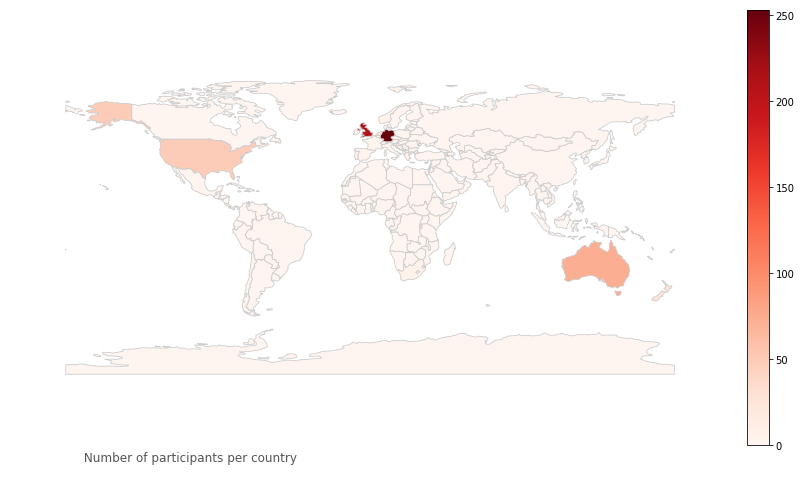

In [14]:
fig, ax = plt.subplots(1)
ax = df_map.plot(ax=ax, column='count', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)

# Add the description
description = """ Number of participants per country"""
plot = ax.annotate(description, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Remove axis
plot = ax.axis('off')

plt.show()

### Create a category world

As said, we are concerned about some countries specifically. However, we collect information about other countries as well. To avoid any confusion and having too much countries to plot, we group all of them into one category "world"

In [15]:
# Create a list of all countries of interest
list_countries = ['United Kingdom', 'Australia', 'United States', 'Germany', 'New Zealand', 'Netherlands', 'South Africa']

# Create a new columns if "World" if the country is not in the list
df['Country'] = df['socio1. In which country do you work?'].apply(lambda x: x if x in list_countries else 'World')

### Difference with the previous year

Several countries did the survey last year, here a summary of the difference in the amount of participants.

In [16]:
results = dict()
for country in df[df['Year']== 2017]['Country'].unique():
    current_year = df[df['Year']== 2018]['Country'].value_counts()[country]
    previous_year = df[df['Year']== 2017]['Country'].value_counts()[country]
    results[country] = {'2017': previous_year, '2018': current_year}
diff_year_participants = pd.DataFrame.from_dict(results, orient='index')
diff_year_participants['Difference between 2017 and 2018'] = diff_year_participants['2018'] - diff_year_participants['2017']

# Displaying the results
diff_year_participants

,2017,2018,Difference between 2017 and 2018
Germany,325,253,-72
Netherlands,77,29,-48
South Africa,22,5,-17
United Kingdom,253,209,-44
United States,164,49,-115


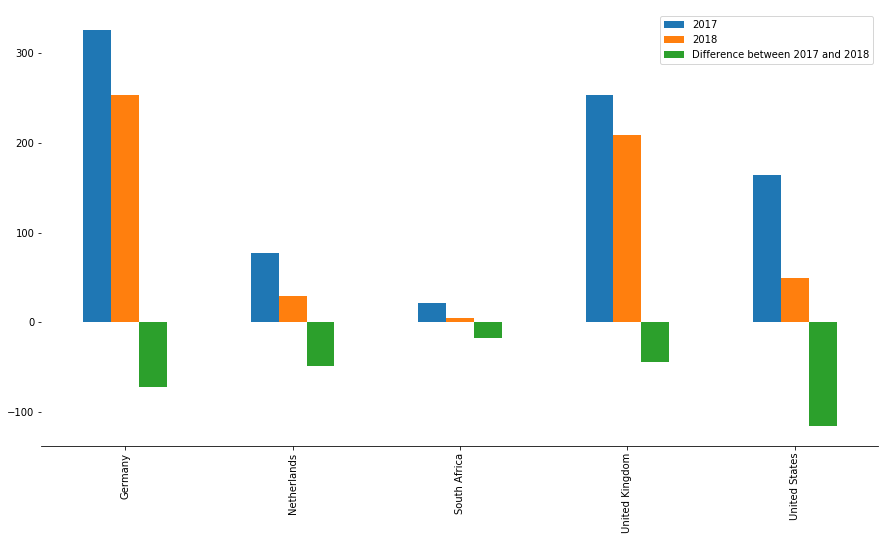

In [17]:
# Plotting the difference
ax = diff_year_participants.plot(kind='bar')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

plt.show()

## Selecting valid participants only

However, on this total of participants, we only want the participants that code software during their work. 
We had a specific question for this purpose. We asked the participants if they are writing software or if they are leading a group of software developers. Each of these questions had the possibility of Yes/No answer. Here the exact wording of the questions:

* Do you write software for academic research as part of your job
* Does the majority of your role comprise leading a group of software developers or RSEs?

We will only select the participants who answered `Yes` to at least one question.

In [18]:
# Get the count of Y/N for the software developers
soft_dev = df['rse1. Do you write software for academic research as part of your job'].value_counts().to_frame()

# Get the count of Y/N for the leader developers
soft_lead = df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?'].value_counts().to_frame()

# Get the count for Y/N to any of the question
df['any_rse'] = np.where((df['rse1. Do you write software for academic research as part of your job'] == 'Yes') | (df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?']), 'Yes', 'No')
soft_any = df['any_rse'].value_counts().to_frame()

# Create one df
result = pd.concat([soft_dev, soft_lead, soft_any], axis=1)#, sort=False)

# Rename columns
result.columns = ['Write software', 'Lead a team of software developers', 'At least one of the two']
result

,Write software,Lead a team of software developers,At least one of the two
No,52,689,14
Yes,1466,293,1504


This table is for both 2017 and 2018 year.For any further analysis, we remove the participants that answered 'No' at both of the question to only keep the ones that have work involving software development for both year to ensure a proper comparison. 

In [19]:
# Filtering the df
df = df[df['any_rse'] == 'Yes']
# drop the column `any_rse` as no use anymore
df.drop(['any_rse'], axis=1, inplace=True)

This brings the number of participants analysed to:

In [20]:
results = pd.DataFrame.from_dict([{'Participants in 2017': len(df[df['Year'] == 2017]), 
 'Participants in 2018': len(df[df['Year'] == 2018])}])
results

,Participants in 2017,Participants in 2018
0,828,676


# Education and previous formation

## Levels of education 

The education questions is tight to each countries as each of them have their own educative system. Therefore this section is separated between all countries.
All of them had the same question:
* What is the highest level of education you have attained?
But the list of diploma was different for each. 
If a participant answered from another country than the one listed at the beginning of the notebook, they could answer with a free text.

In [21]:
# Create a separated df for following sections
df_edu_per_country = df[df['Year'] == 2018][['Country', 'edu1. What is the highest level of education you have attained?']].copy()
df_edu_per_country.columns = ['Country', 'Education']

### Australia

In [22]:
# Set up variables
country = 'Australia'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Australia,,
AQF 10 - Doctoral Degree,45,61.64
AQF 8 - Bachelor Honours Degree / Graduate Certificate / Graduate Diploma,11,15.07
AQF 7 - Bachelor Degree,9,12.33
AQF 9 - Masters Degree,8,10.96


### Germany

In [23]:
# Set up variables
country = 'Germany'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Germany,,
Master degree,124,49.01
Doctorate,105,41.50
Undergraduate degree,16,6.32
"Final secondary-school examinations, general qualification for university entrance",6,2.37
Other,2,0.79


### Netherlands

In [24]:
# Set up variables
country = 'Netherlands'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Netherlands,,
PhD,14,48.28
WO (Wetenschappelijk onderwijs) Master,11,37.93
HBO (Hoger beroepsonderwijs) Master,2,6.90
HBO (Hoger beroepsonderwijs) Bachelor,1,3.45
WO (Wetenschappelijk onderwijs) Bachelor,1,3.45


### New Zealand

In [25]:
# Set up variables
country = 'New Zealand'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for New Zealand,,
Doctorate,10,37.04
Master degree,7,25.93
Undergraduate degree,7,25.93
"Further Education (NVQ A-Level, ...)",2,7.41
Other,1,3.70


### South Africa

In [26]:
# Set up variables
country = 'South Africa'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for South Africa,,
Master degree,2,40.0
Other,1,20.0
Doctorate,1,20.0
"Further Education (NVQ A-Level, ...)",1,20.0


### United Kingdom

In [27]:
# Set up variables
country = 'United Kingdom'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for United Kingdom,,
Doctorate,145,69.71
Master degree,43,20.67
Undergraduate degree,19,9.13
GSCEs,1,0.48


### United States

In [28]:
# Set up variables
country = 'United States'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for United States,,
Doctorate,22,44.90
Master degree,15,30.61
Undergraduate degree,11,22.45
Other,1,2.04


### Rest of the World

In [29]:
# Set up variables
country = 'World'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for World,,
PhD,13,41.94
Ph.D.,2,6.45
phd,1,3.23
Master,1,3.23
Master degree,1,3.23
Masters,1,3.23
PhD in progress,1,3.23
master,1,3.23
Dr. phil.,1,3.23


### Comparison between countries

Even if the countries have different education levels, it is possible to match them on the common "Doctorate" and "Master degree". 
Therefore we compare them with these two equivalent levels and merge all others under the category "other".

In [30]:
# Create dictionary to replace values. These values may not be present in the current df but are present in the
# potential answers
dict_values = {'PhD': 'Doctorate', 
               'AQF 10 - Doctoral Degree': 'Doctorate',
               'HBO (Hoger beroepsonderwijs) Master': 'Master degree',
               'WO (Wetenschappelijk onderwijs) Master': 'Master degree',
               'AQF 9 - Masters Degree': 'Master degree'}
list_value_to_keep = ['Doctorate', 'Master degree', np.NaN]

# Replace the value in education
df_edu_per_country['Education'] = df_edu_per_country['Education'].replace(dict_values)

# Create a new columns if "World" if the country is not in the list
def merge_edu(x):
    if x in list_value_to_keep:
        return x
    elif x == np.NaN:
        return x
    else:
        return 'Other'
    
# Apply the function to a new columns
df_edu_per_country['Level of education'] = df_edu_per_country['Education'].apply(merge_edu)

# Count the values per countries
df_edu_comparison = df_edu_per_country.groupby('Country')['Level of education'].value_counts().rename('Total count').reset_index()

# Add a percentage of each type of diploma per countries
df_edu_comparison['Percentage per countries'] = (df_edu_comparison['Total count'] / df_edu_comparison.groupby('Country')['Total count'].transform('sum')*100).round(2)

# Display the results
df_edu_comparison

,Country,Level of education,Total count,Percentage per countries
0,Australia,Doctorate,45,61.64
1,Australia,Other,20,27.40
2,Australia,Master degree,8,10.96
3,Germany,Master degree,124,49.01
4,Germany,Doctorate,105,41.50
5,Germany,Other,24,9.49
6,Netherlands,Doctorate,14,48.28
7,Netherlands,Master degree,13,44.83
8,Netherlands,Other,2,6.90
9,New Zealand,Doctorate,10,37.04


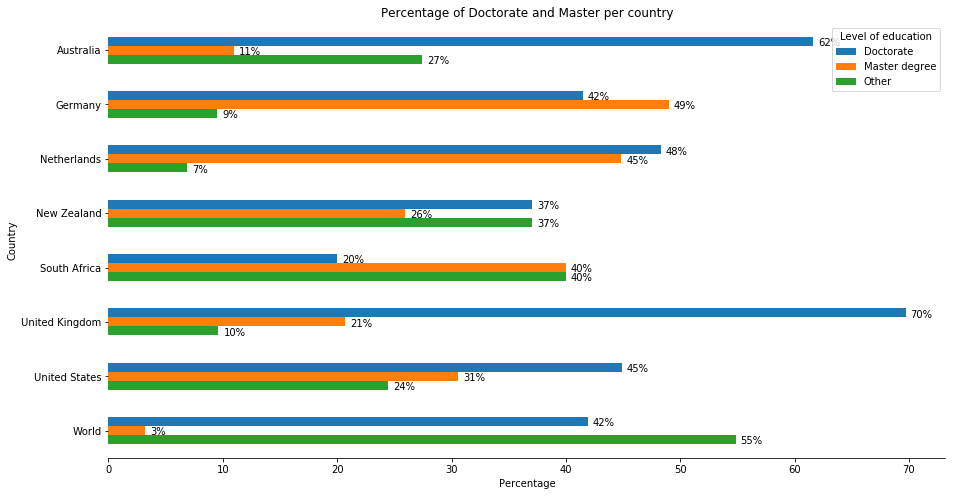

In [31]:
fig, ax = plt.subplots()
df_plot = df_edu_comparison.pivot(index='Country', 
                        columns='Level of education', 
                        values='Percentage per countries')
df_plot.plot(kind='barh',
                  title='Percentage of Doctorate and Master per country',
                  grid=False, ax=ax)

ax.set(xlabel="Percentage", ylabel="Country")

ax.invert_yaxis()  # when barh option, the bars are inverted 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 
for p in ax.patches:
    if int(round(p.get_width())) > 0:
        ax.annotate('{}%'.format(str(int(round(p.get_width())))), 
                                 (p.get_x() + p.get_width(), p.get_y()), 
                                  xytext=(5, -9),
                                  textcoords='offset points')
plt.show();

## Academic field for education

Alongside of question about education level we also asked the participants in which field they finished their highest level of education. 
Here again the propositions were specific to each countries.

In [32]:
# Create a column that merge all education columns
df['Academic field'] = df[df['Year'] == 2018]['edu2. In which discipline is your highest academic qualification?']

# There are numbers in some of the fields, removing them as they are not needed
def remove_digit(s):
    try:
        return ''.join([i for i in s if not i.isdigit()])
    except TypeError:
        return s

df['Academic field'] = df['Academic field'].apply(remove_digit)

# Create a separated df for following sections
df_edu_aca_per_country = df[['Country', 'Academic field']].copy()

### Australia

In [33]:
# Set up variables
country = 'Australia'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Australia,,
Physical Sciences,16,22.22
Information and Computing Sciences,15,20.83
Biological Sciences,13,18.06
Engineering,8,11.11
Earth Sciences,7,9.72
Mathematical Sciences,6,8.33
Psychology and Cognitive Sciences,1,1.39
Environmental Sciences,1,1.39
Philosophy and Religious Studies,1,1.39


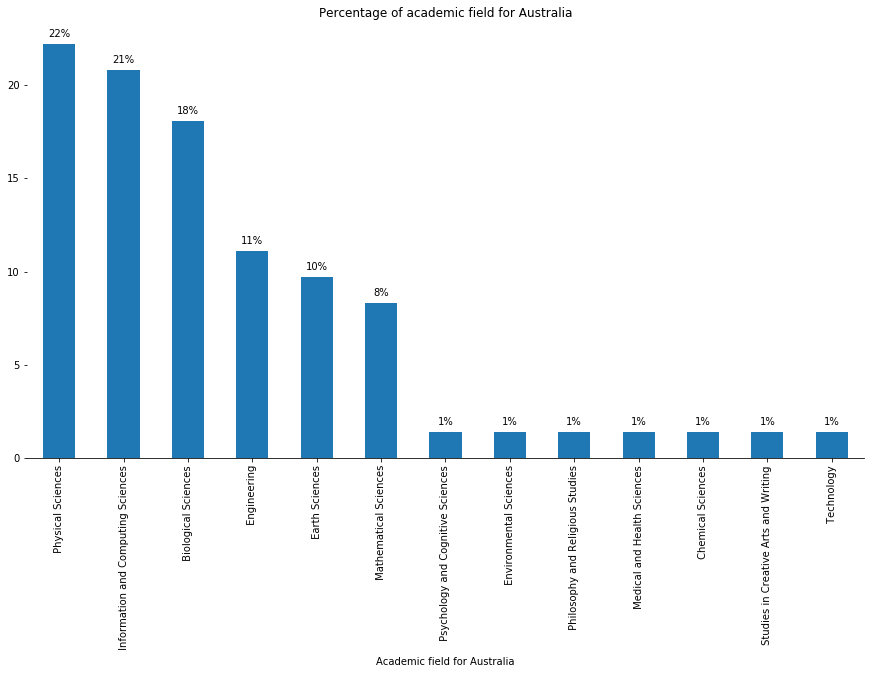

In [34]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.0f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### Germany

In [35]:
# Set up variables
country = 'Germany'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Germany,,
Computer Science,70,27.89
Physics and Astronomy,61,24.30
Mathematics,19,7.57
Geography & Environmental Sciences,17,6.77
Biological Sciences,15,5.98
Electrical & Electronic Engineering,12,4.78
Mechanical Engineering,8,3.19
Materials Technology,5,1.99
Chemical Engineering,5,1.99


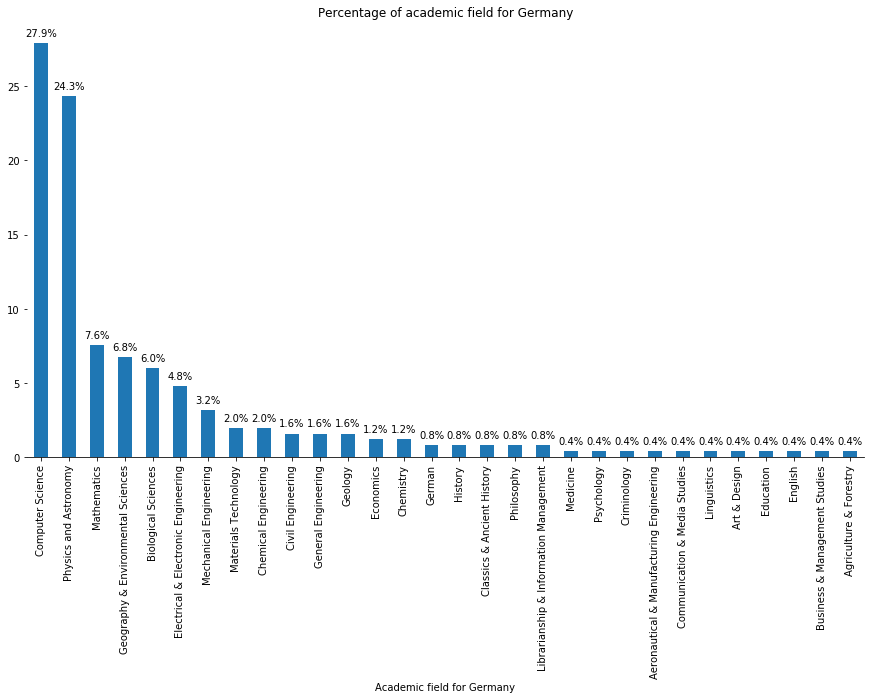

In [36]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### Netherlands

In [37]:
# Set up variables
country = 'Netherlands'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Netherlands,,
Physics and Astronomy,7,24.14
Biological Sciences,7,24.14
Computer Science,6,20.69
Electrical & Electronic Engineering,1,3.45
Mathematics,1,3.45
Civil Engineering,1,3.45
Geography & Environmental Sciences,1,3.45
Politics,1,3.45
Chemistry,1,3.45


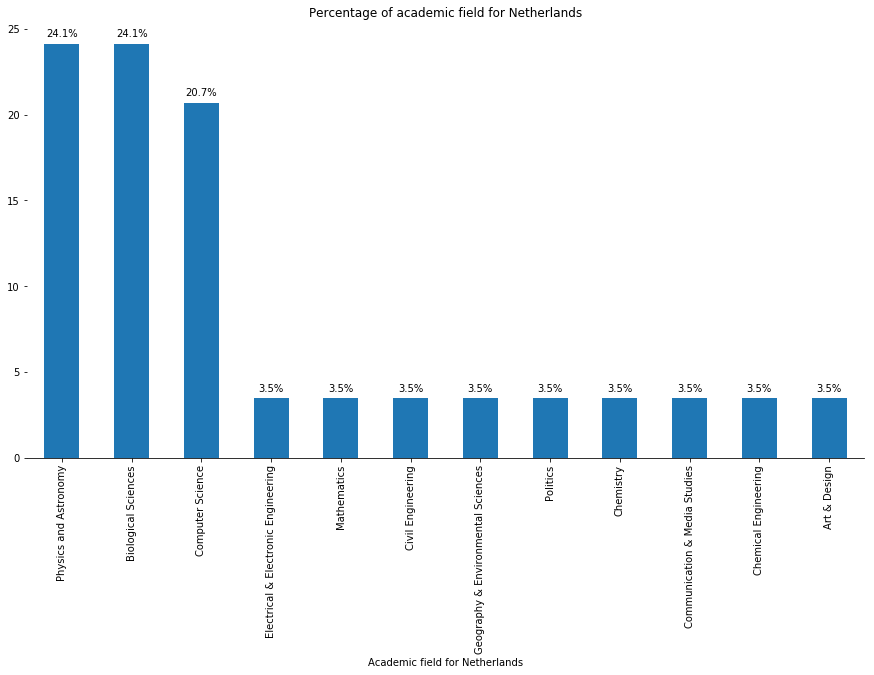

In [38]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### New Zealand

In [39]:
# Set up variables
country = 'New Zealand'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for New Zealand,,
Biological Sciences,5,18.52
Computer Science,5,18.52
Mathematics,4,14.81
Physics and Astronomy,3,11.11
Business & Management Studies,2,7.41
Mechanical Engineering,2,7.41
Electrical & Electronic Engineering,2,7.41
General Engineering,1,3.70
Geography & Environmental Sciences,1,3.70


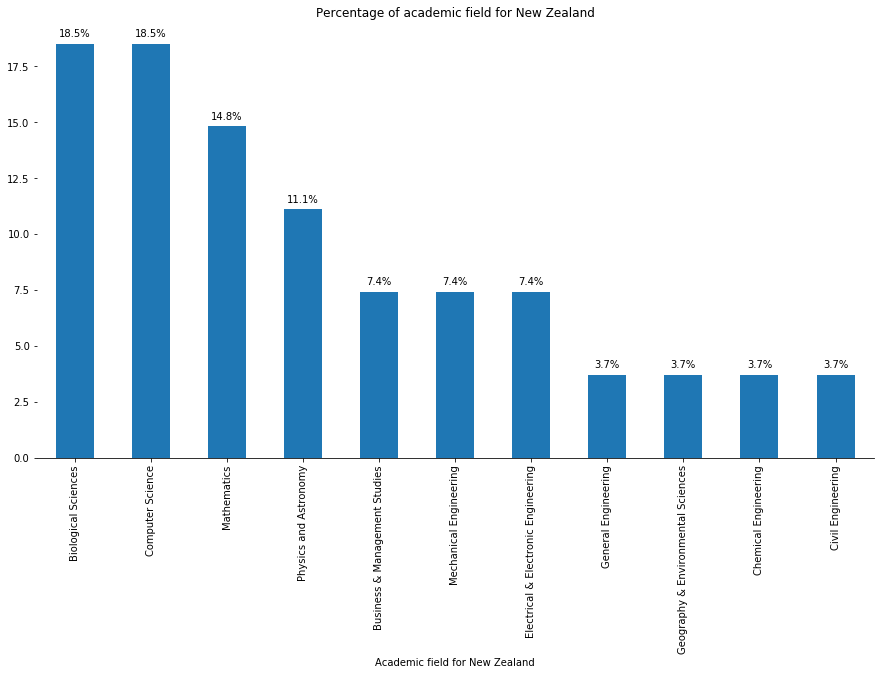

In [40]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### South Africa

In [41]:
# Set up variables
country = 'South Africa'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for South Africa,,
Computer Science,2,50.0
Physics and Astronomy,1,25.0
Economics,1,25.0


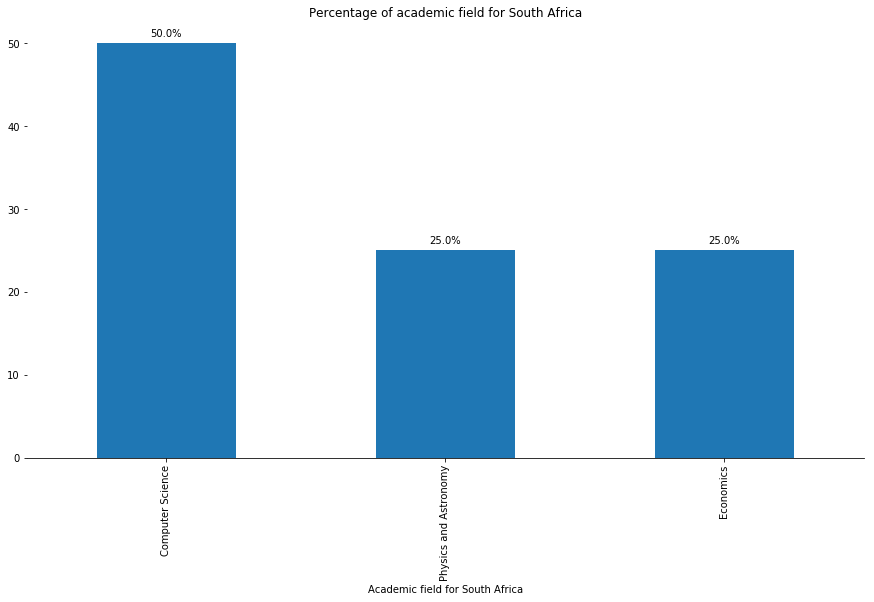

In [42]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### United Kingdom

In [43]:
# Set up variables
country = 'United Kingdom'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for United Kingdom,,
Physics and Astronomy,68,32.85
Computer Science,52,25.12
Biological Sciences,22,10.63
Mathematics,15,7.25
Chemistry,12,5.80
Geography & Environmental Sciences,11,5.31
Electrical & Electronic Engineering,6,2.90
General Engineering,4,1.93
Geology,4,1.93


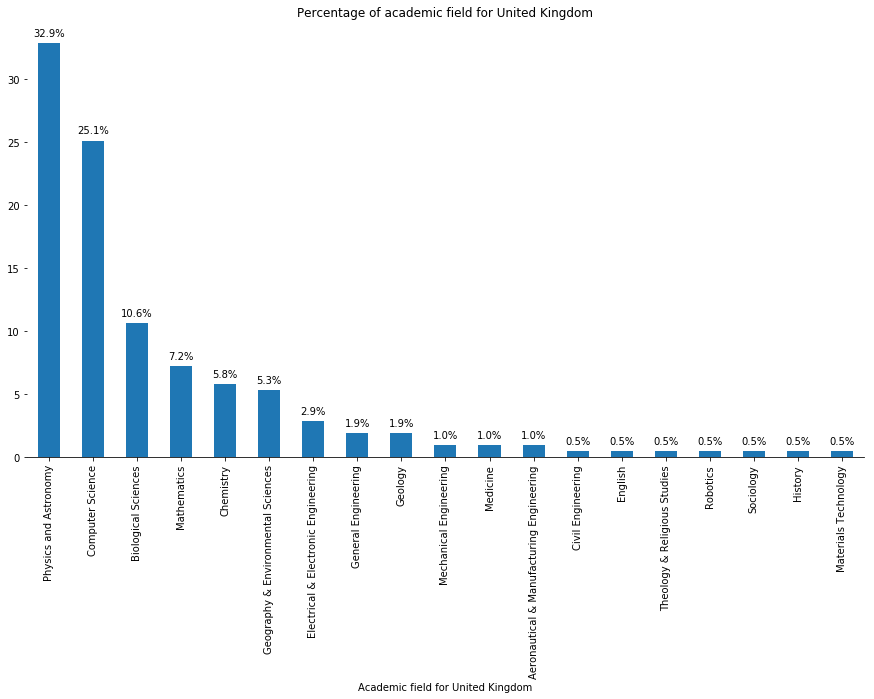

In [44]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### United States

In [45]:
# Set up variables
country = 'United States'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for United States,,
Computer Science,12,24.49
Biological Sciences,8,16.33
Physics and Astronomy,7,14.29
Mathematics,7,14.29
Music,2,4.08
Economics,2,4.08
History,1,2.04
Philosophy,1,2.04
Chemistry,1,2.04


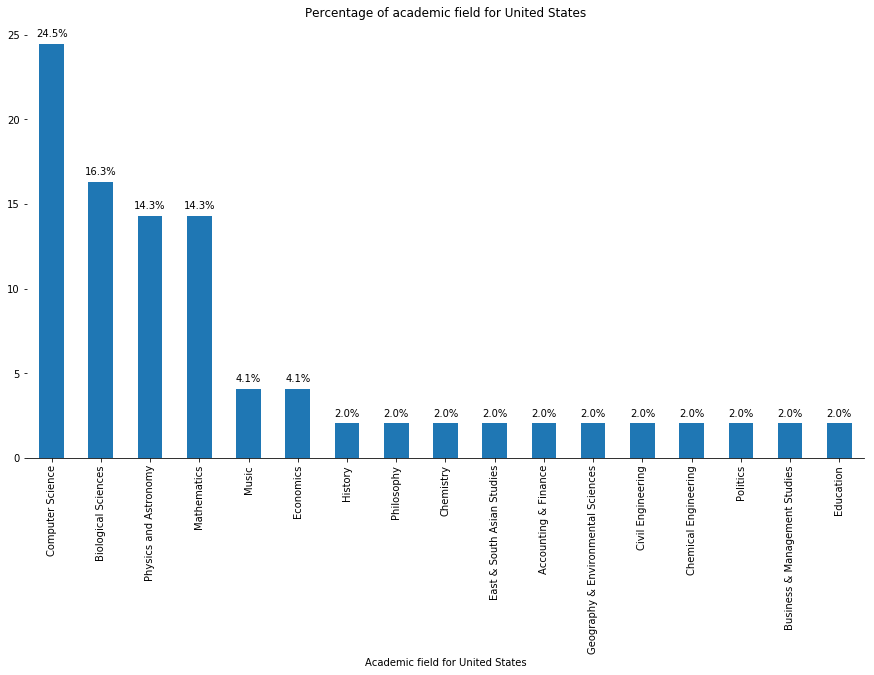

In [46]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### Rest of the world

In [47]:
# Set up variables
country = 'World'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for World,,
Physics and Astronomy,8,25.81
Biological Sciences,6,19.35
Mathematics,3,9.68
Computer Science,3,9.68
Geography & Environmental Sciences,2,6.45
Education,2,6.45
Business & Management Studies,1,3.23
Electrical & Electronic Engineering,1,3.23
Chemical Engineering,1,3.23


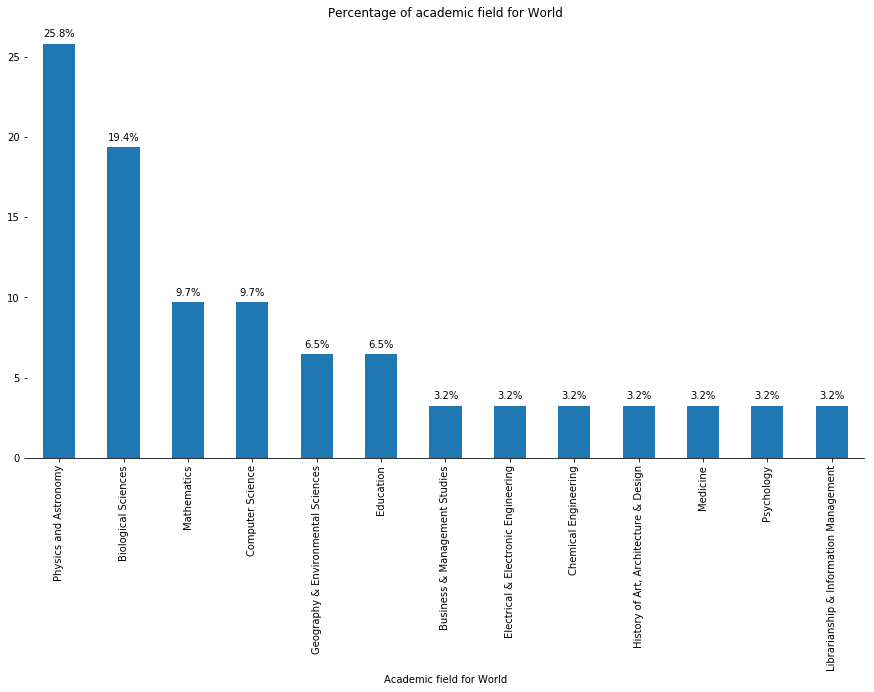

In [48]:
fig, ax = plt.subplots()

df_edu.plot(kind='bar',
            y='Percentage',
            title='Percentage of academic field for {}'.format(country),
            grid=False, ax=ax, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}%".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
plt.show();

### Comparison between countries

In [49]:
# Count the values per countries
df_edu_comparison = df_edu_aca_per_country.groupby('Country')['Academic field'].value_counts().rename('Total count').reset_index()

# Add a percentage of each type of diploma per countries
df_edu_comparison['Percentage per countries'] = (df_edu_comparison['Total count'] / df_edu_comparison.groupby('Country')['Total count'].transform('sum')*100).round(2)

# Display the results
df_edu_comparison

,Country,Academic field,Total count,Percentage per countries
0,Australia,Physical Sciences,16,22.22
1,Australia,Information and Computing Sciences,15,20.83
2,Australia,Biological Sciences,13,18.06
3,Australia,Engineering,8,11.11
4,Australia,Earth Sciences,7,9.72
5,Australia,Mathematical Sciences,6,8.33
6,Australia,Chemical Sciences,1,1.39
7,Australia,Environmental Sciences,1,1.39
8,Australia,Medical and Health Sciences,1,1.39
9,Australia,Philosophy and Religious Studies,1,1.39


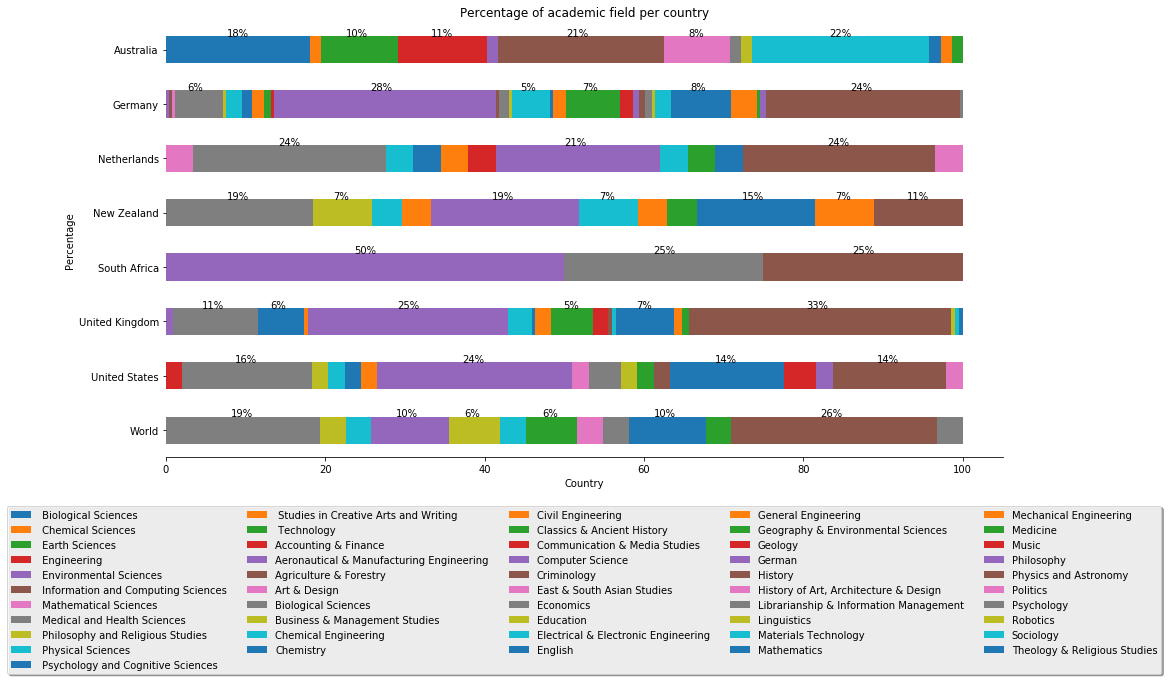

In [50]:
fig, ax = plt.subplots()
df_plot = df_edu_comparison.pivot(index='Country', 
                        columns='Academic field', 
                        values='Percentage per countries')

df_plot.plot(kind='barh',
                  title='Percentage of academic field per country',
                  grid=False, ax=ax, stacked=True)

ax.set(xlabel="Country", ylabel="Percentage")

ax.invert_yaxis()  # when barh option, the bars are inverted 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
for p in ax.patches:
    if int(round(p.get_width())) >= 5:
        ax.annotate('{}%'.format(str(int(round(p.get_width())))), 
                    (p.get_x() + int(p.get_width())/2., p.get_y()+ int(p.get_height())/2.),
                    ha='center')

plt.show();

# Current employment

## Academic field of work

We asked the participants, in which field they are working. With that question, it is possible to see which current field employed the most of RSE/RSD. The questions was specific to each country and was multiple choice. Each participant could choose several fields. We then calculate the different proportion by dividing each field by the total of participants that have selected at least one option. 


In [84]:
# Getting all the questions about the academic field of the current employment. 
column_work = [x for x in df.columns if x[:12] == 'currentEmp13']
to_sub = column_work + ['Country', 'Year']
# Subsetting the df
df_current_field = df[to_sub]

In [85]:
def get_academic_field(df, country):
    """
    Check if it is possible to get the difference from previous year.
    Return a dataframe with the count of each field
    """
    # Get the count for the 2018 year
    df_country_2018 = df[(df['Country'] == country) & (df['Year'] == 2018)]
    count_current_field_2018 = count_multi_choice(df_country_2018).reset_index()
    # Get the count for the 2017 year if it exists
    df_country_2017 = df[(df['Country'] == country) & (df['Year'] == 2017)]
    try:
        count_current_field_2017 = count_multi_choice(df_country_2017).reset_index()
        # Calculate the difference
        count_current_field_2018['Difference'] = (count_current_field_2018['Count'] - count_current_field_2017['Count']).to_frame()
    except KeyError:
        pass
    return count_current_field_2018

In [86]:
def plot_academic_field(df):
    # Plotting current working field and the difference from last year
    try:
        diff = df['Difference']
        fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[7, 1]})

        ind = np.arange(len(df['Field']))

        # current field
        axs[0].bar(ind, df['Count'], align='center')
        axs[0].set_title('Current proportion of field')
        #axs[0].xaxis.set_visible(False)

        # Difference from last year
        axs[1].bar(ind, df['Difference'], color=df['Difference'].apply(lambda x: 'g' if x>0 else 'orange'))
        axs[1].set_title('Difference from last year')
        plt.xticks(ind, df['Field'], rotation=90)
        for ax in axs:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
    

    except KeyError:
        # Set up columns
        result.sort_values('Count', ascending=False, inplace=True)
        ax = result.plot(kind='bar', x='Field', y='Count', grid=False, legend=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False) 
    plt.show();

### Australia

In [54]:
# Get the count for the 2017 year
country = 'Australia'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count
0,08 Information and Computing Sciences,47.297297
1,06 Biological Sciences,37.837838
2,02 Physical Sciences,29.729730
3,11 Medical and Health Sciences,25.675676
4,10 Technology,25.675676
5,04 Earth Sciences,24.324324
6,05 Environmental Sciences,24.324324
7,01 Mathematical Sciences,22.972973
8,09 Engineering,21.621622
9,03 Chemical Sciences,10.810811


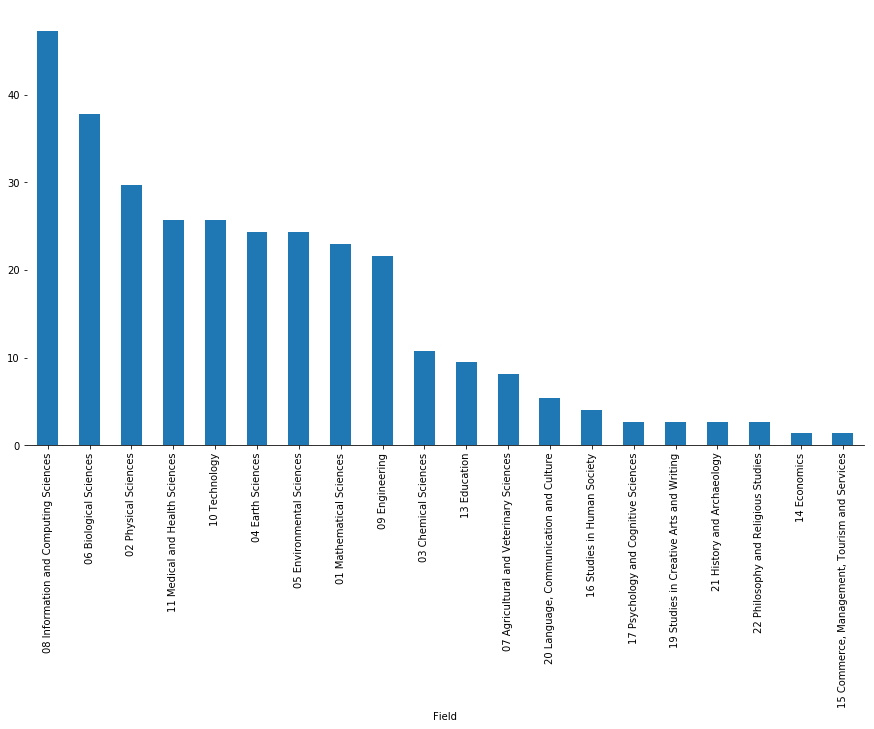

In [55]:
plot_academic_field(result)

### Germany

In [56]:
# Get the count for the 2017 year
country = 'Germany'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count,Difference
0,Computer Science,42.292490,7.523259
1,Physics and Astronomy,25.296443,-2.088173
2,Biological Sciences,16.205534,-10.563697
3,Geography & Environmental Sciences,15.810277,-4.497416
4,Electrical & Electronic Engineering,11.067194,1.836424
5,Mathematics,10.671937,3.287321
6,Mechanical Engineering,9.881423,3.727577
7,Robotics,7.905138,2.366677
8,General Engineering,7.509881,2.279112
9,Materials Technology,6.324111,1.093341


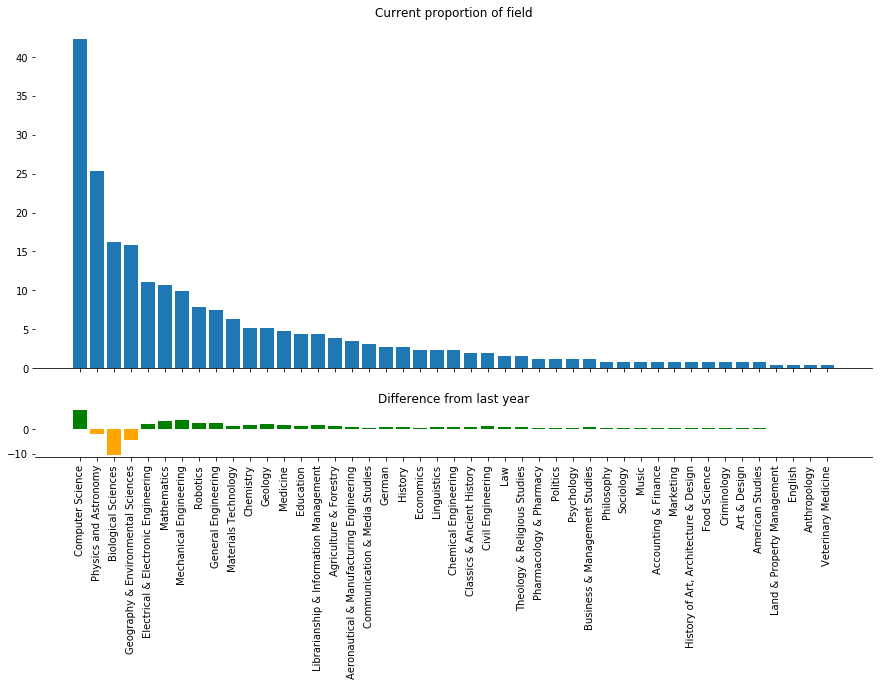

In [57]:
plot_academic_field(result)

### Netherlands

In [58]:
# Get the count for the 2017 year
country = 'Netherlands'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count,Difference
0,Biological Sciences,34.482759,-18.850575
1,Computer Science,24.137931,-3.862069
2,Physics and Astronomy,20.689655,-5.977011
3,Medicine,20.689655,6.022989
4,Geography & Environmental Sciences,17.241379,2.574713
5,Linguistics,10.344828,-2.988506
6,Chemistry,10.344828,-2.988506
7,Communication & Media Studies,6.896552,-5.103448
8,History,6.896552,-1.103448
9,Art & Design,3.448276,-3.218391


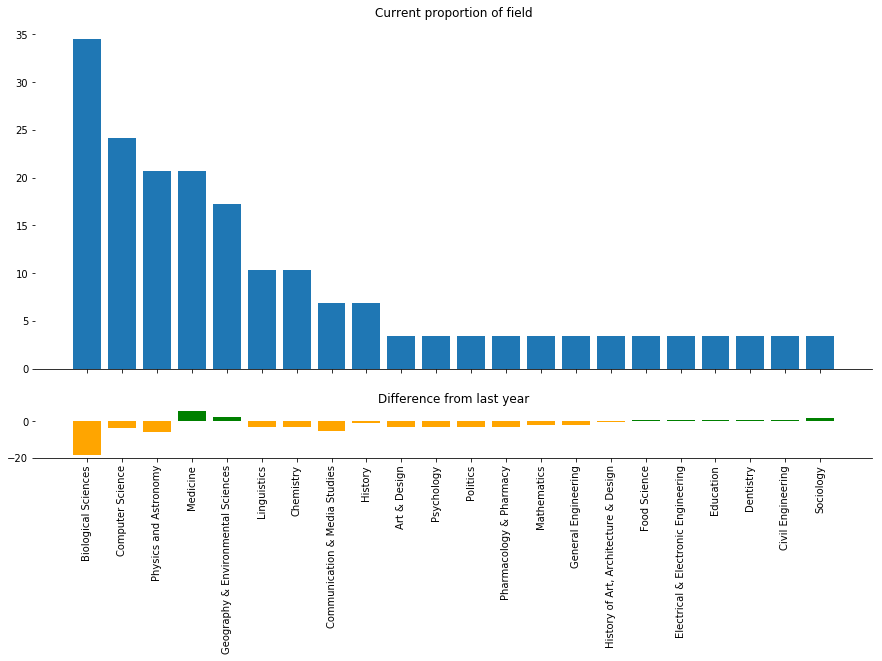

In [59]:
plot_academic_field(result)

### New Zealand

In [60]:
# Get the count for the 2017 year
country = 'New Zealand'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count
0,Geography & Environmental Sciences,51.851852
1,Computer Science,33.333333
2,Biological Sciences,25.925926
3,Physics and Astronomy,18.518519
4,Civil Engineering,18.518519
5,Mathematics,14.814815
6,Geology,11.111111
7,Mechanical Engineering,11.111111
8,Electrical & Electronic Engineering,11.111111
9,General Engineering,11.111111


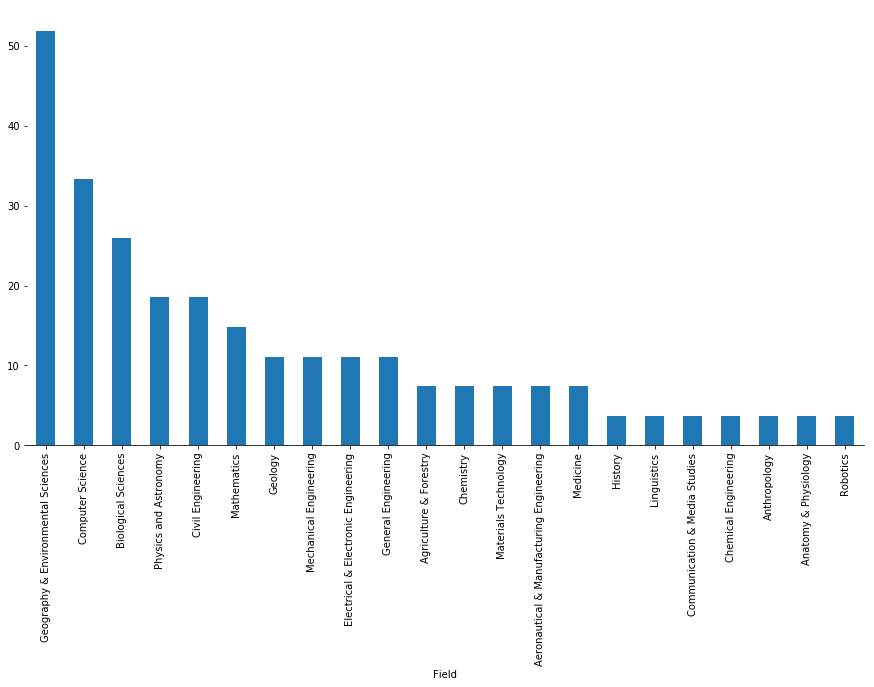

In [61]:
plot_academic_field(result)

### South Africa

In [62]:
# Get the count for the 2017 year
country = 'South Africa'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count,Difference
0,Biological Sciences,40.0,-23.157895
1,Computer Science,40.0,13.684211
2,Economics,20.0,-1.052632
3,Education,20.0,9.473684
4,Physics and Astronomy,20.0,14.736842


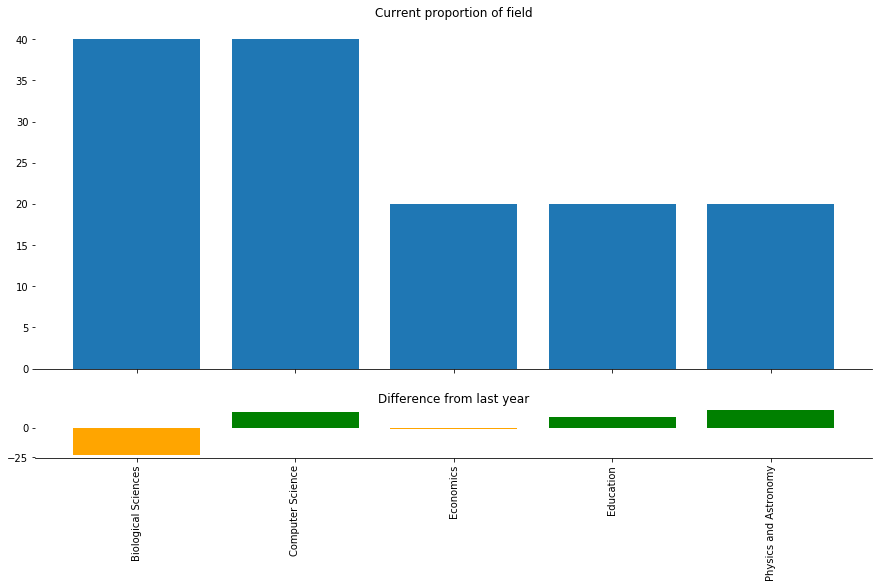

In [63]:
plot_academic_field(result)

### United Kingdom

In [64]:
# Get the count for the 2017 year
country = 'United Kingdom'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count,Difference
0,Computer Science,38.461538,-4.627892
1,Physics and Astronomy,36.057692,1.098343
2,Biological Sciences,27.403846,-5.116479
3,Geography & Environmental Sciences,18.750000,2.083333
4,Medicine,17.307692,1.454034
5,Chemistry,15.865385,0.824734
6,Mathematics,12.019231,-1.801907
7,General Engineering,7.211538,-2.951063
8,Education,7.211538,-2.544559
9,Mechanical Engineering,7.211538,-0.918543


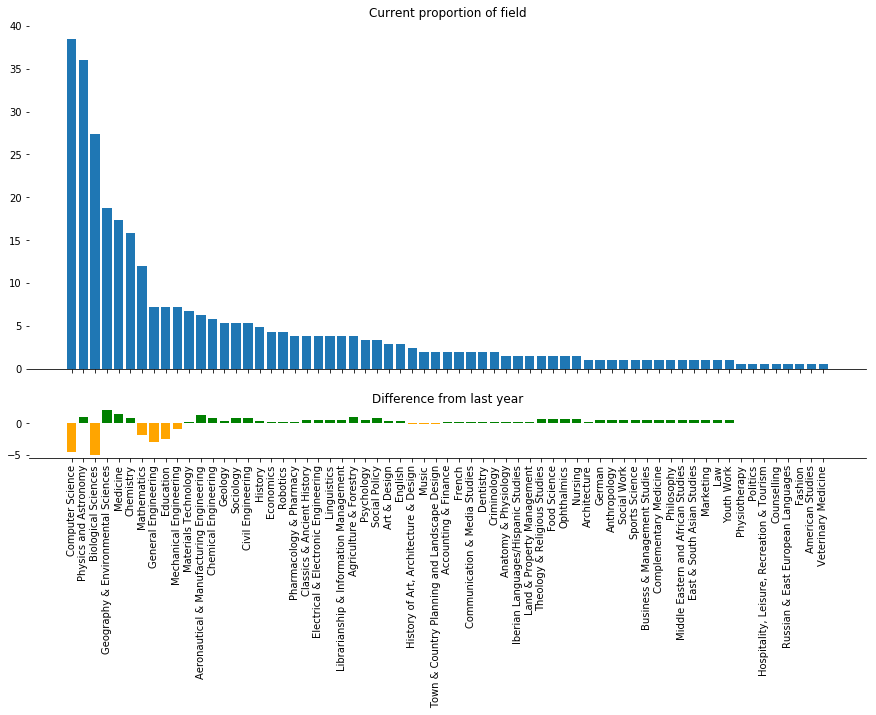

In [65]:
plot_academic_field(result)

### United States

In [66]:
# Get the count for the 2017 year
country = 'United States'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count,Difference
0,Computer Science,51.020408,-5.421310
1,Biological Sciences,38.775510,6.260173
2,Physics and Astronomy,18.367347,-6.172530
3,Mathematics,18.367347,4.256917
4,Geography & Environmental Sciences,16.326531,2.216101
5,Economics,12.244898,-1.865531
6,Geology,8.163265,-4.106673
7,Medicine,8.163265,-4.106673
8,Electrical & Electronic Engineering,8.163265,0.187805
9,Business & Management Studies,6.122449,-1.853011


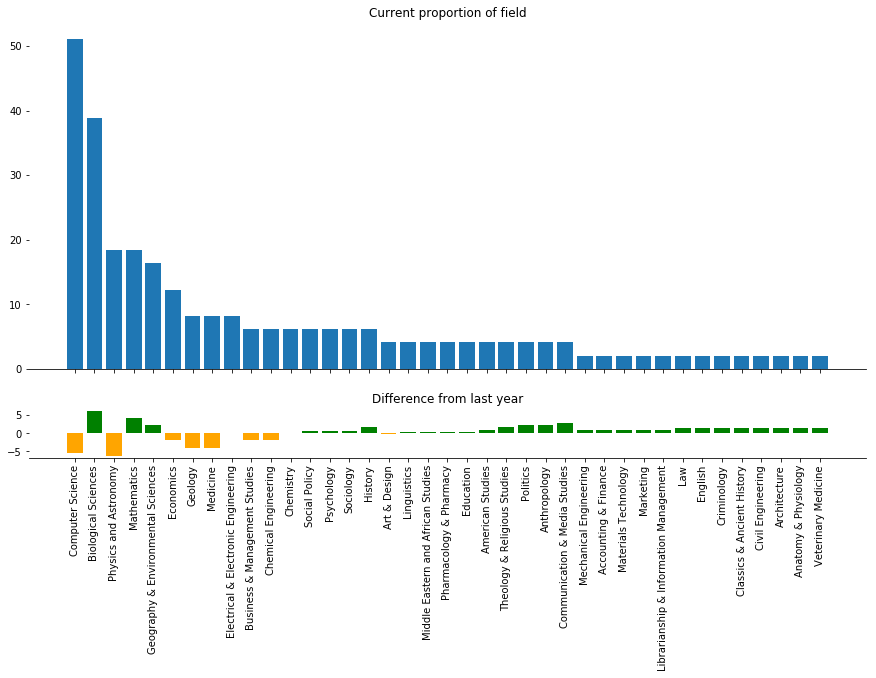

In [67]:
plot_academic_field(result)

### Rest of the World

In [68]:
# Get the count for the 2017 year
country = 'World'
result = get_academic_field(df_current_field, country)
# Showing the results
result

,Field,Count
0,Biological Sciences,38.709677
1,Computer Science,38.709677
2,Mathematics,16.129032
3,Physics and Astronomy,16.129032
4,Geography & Environmental Sciences,16.129032
5,Education,12.903226
6,Medicine,9.677419
7,Sociology,6.451613
8,Materials Technology,6.451613
9,History,6.451613


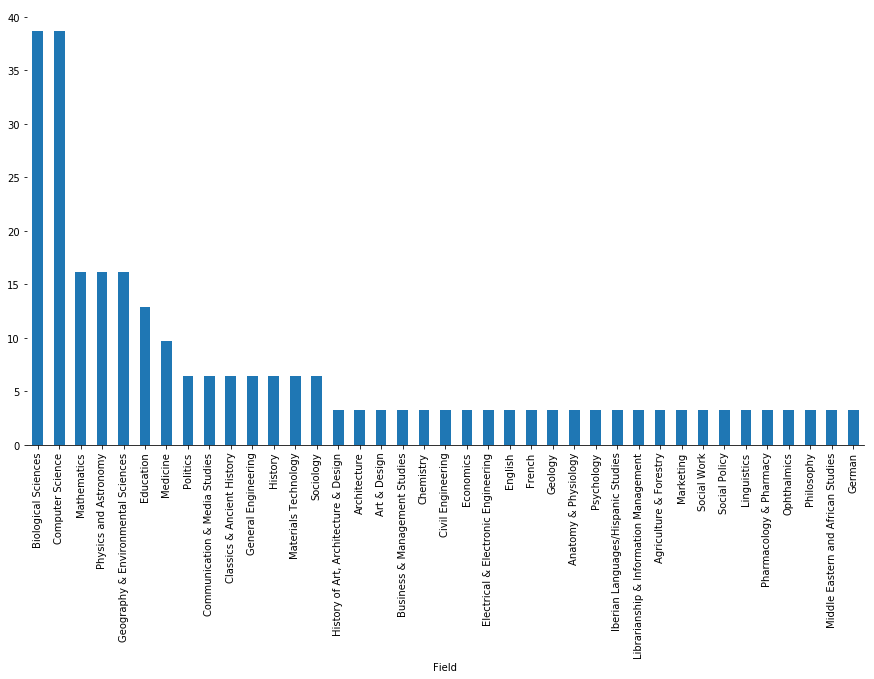

In [69]:
plot_academic_field(result)

## How time is spent

RSE/RSE are supposed to be an hybrid role, compared to pure software developer. They bring a knowledge from their field but also are developing software. To capture this different tasks they may do during their work, we asked them how they spend their time. We specifically asked for the following questions:
* On average, how much of your time is spent developing software
* On average, how much of your time is spent on research
* On average, how much of your time is spent on management
* On average, how much of your time is spent on teaching
* On average, how much of your time is spent on other activities

They answered with a likert scale from *1 (None at all)* to *10 (All my time)*.

The same questions asked them how much time they wanted to spend on these activities. With that it was possible to see if discrepancies exist between what they actual do and what they want to do. 

To calculate the difference between what they want and what they do, we only substract the answer they gave us to **wish to spent** the  with the answer they gave us to the **time spent**. It is therefore possible to understand the results as:
1. The result is zero: it is a total adequation between what they do and what they want. 
1. The result is negative: They wish to spend less time to do that activity
1. The result is positive: They wish to spend more time to do that activity



In [70]:
# Create the two df containing time spent and time they wish they could spend.

# Information about time spent
df_time_spent = df[df['Year'] == 2018][['Country',
                                        'time1can. On average, how much of your time is spent developing software?',
                                        'time2can. On average, how much of your time is spent on research',
                                        'time3can. On average, how much of your time is spent on management',
                                        'time4can. On average, how much of your time is spent on teaching',
                                        'time5can. On average, how much of your time is spent on other activities']].copy()
# Information about the time they wish to spend
df_time_wish = df[df['Year'] == 2018][['Country',
                                       'timeLike6zaf. In an average month, how much time would you like to spend on software development?',
                                       'timeLike7zaf. In an average month, how much time would you like to spend on research',
                                       'timeLike8zaf. In an average month, how much time would you like to spend on management',
                                       'timeLike9zaf. In an average month, how much time would you like to spend on teaching',
                                       'timeLike10zaf. In an average month, how much time would you like to spend on other activities']].copy()

# Replace the value 1 (None at all) and 10 (all my time) into int
df_time_spent.replace({'\ufeff1 (None at all)': 1, '10 (All my time)': 10}, inplace=True)
df_time_wish.replace({'\ufeff1 (None at all)': 1, '10 (All my time)': 10}, inplace=True)

# Create a new dataframe with the difference between what they do and what they wish
# Create a dataframe to show the difference
dict_time_diff = collections.OrderedDict()
dict_time_diff['Country'] = df_time_spent['Country']
dict_time_diff['Software Development difference'] = df_time_wish['timeLike6zaf. In an average month, how much time would you like to spend on software development?'].astype(float) - df_time_spent['time1can. On average, how much of your time is spent developing software?'].astype(float)  
dict_time_diff['Research difference'] = df_time_wish['timeLike7zaf. In an average month, how much time would you like to spend on research'].astype(float) - df_time_spent['time2can. On average, how much of your time is spent on research'].astype(float)
dict_time_diff['Management difference'] = df_time_wish['timeLike8zaf. In an average month, how much time would you like to spend on management'].astype(float) -  df_time_spent['time3can. On average, how much of your time is spent on management'].astype(float)
dict_time_diff['Teaching difference'] = df_time_wish['timeLike9zaf. In an average month, how much time would you like to spend on teaching'].astype(float) - df_time_spent['time4can. On average, how much of your time is spent on teaching'].astype(float)
dict_time_diff['Other activity difference'] = df_time_wish['timeLike10zaf. In an average month, how much time would you like to spend on other activities'].astype(float) - df_time_spent['time5can. On average, how much of your time is spent on other activities'].astype(float)
df_time_diff = pd.DataFrame.from_dict(dict_time_diff)

In [75]:
def plotting_time_likert(country, df_time_spent=None, df_time_wish=None, df_time_diff=None):
    """"""
    #fig, axs = plt.subplots(3, 1, sharex=True)
    list_plots = list()
    if df_time_spent is not None:
        ax = likert_scale(count_likert(df_time_spent[df_time_spent['Country'] == country], likert_answer=[str(i) for i in range(11)[1:]]).transpose(),
                       normalise=True, legend=True, title_plot='{}: Time spent for each type of activity'.format(country))
        list_plots.append(ax)
    if df_time_wish is not None:
        ax = likert_scale(count_likert(df_time_wish[df_time_wish['Country'] == country], likert_answer=[str(i) for i in range(11)[1:]]).transpose(),
                       normalise=True, legend=True, title_plot='{}: Time wish to spent for each type of activity'.format(country))
    
    if df_time_diff is not None:
        all_unique_diff = [x for x in np.unique(df_time_diff[dict_time_diff['Country'] == country].loc[:, df_time_diff[dict_time_diff['Country'] == country].columns != 'Country'].values)]
        negative_order = [str(x) for x in all_unique_diff if x < 0] + [str(x) for x in all_unique_diff if x >= 0] 
        ax = likert_scale(count_likert(df_time_diff[dict_time_diff['Country'] == country],likert_answer=negative_order).transpose(),
                      normalise=True, legend=True, title_plot='{}: Difference between time wish to spent and actually spent for each type of activity'.format(country))
        list_plots.append(ax)

    for ax in list_plots:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.invert_yaxis()


### Australia

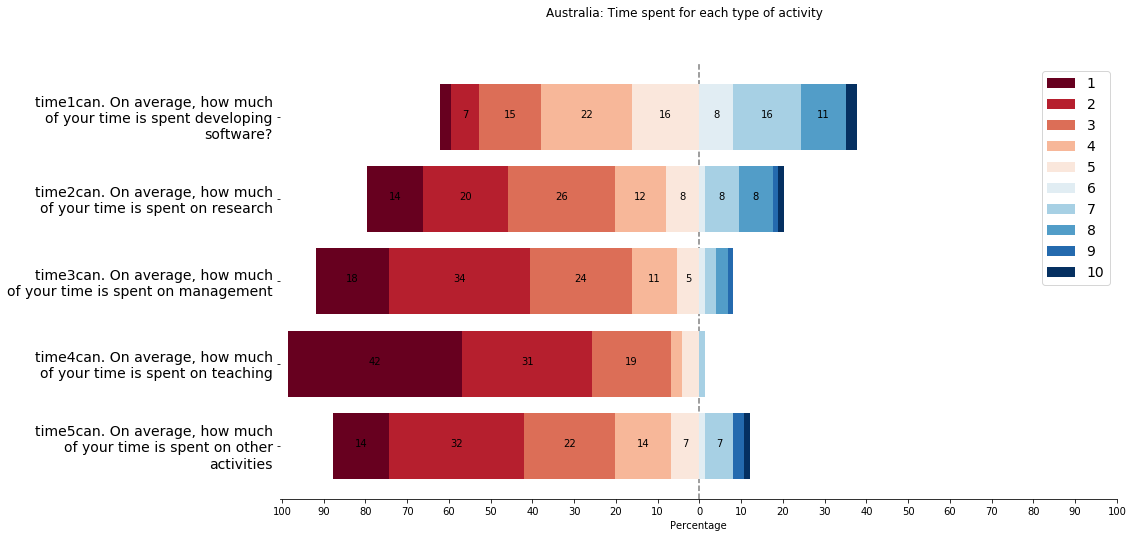

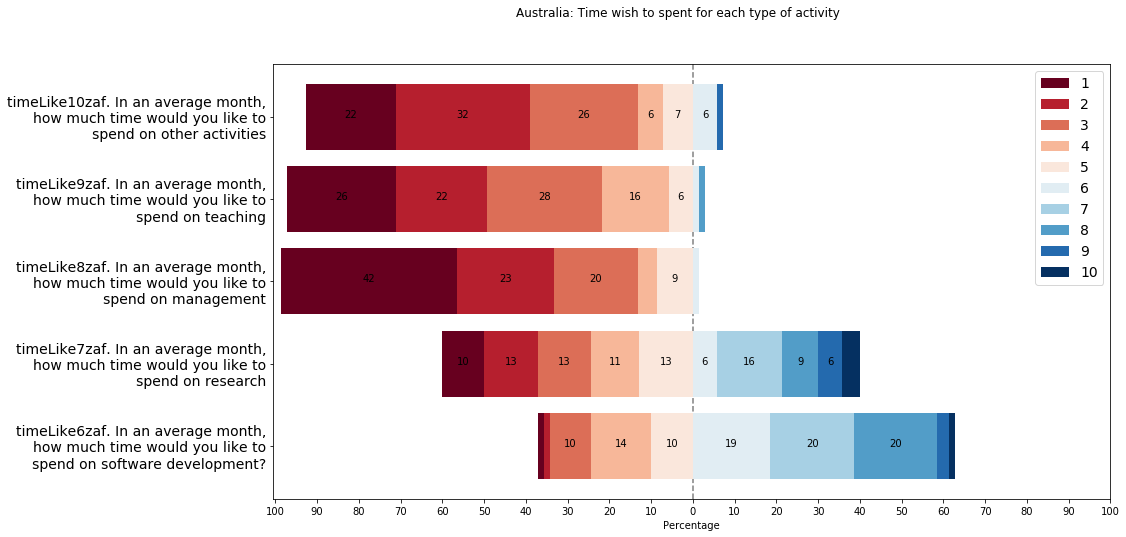

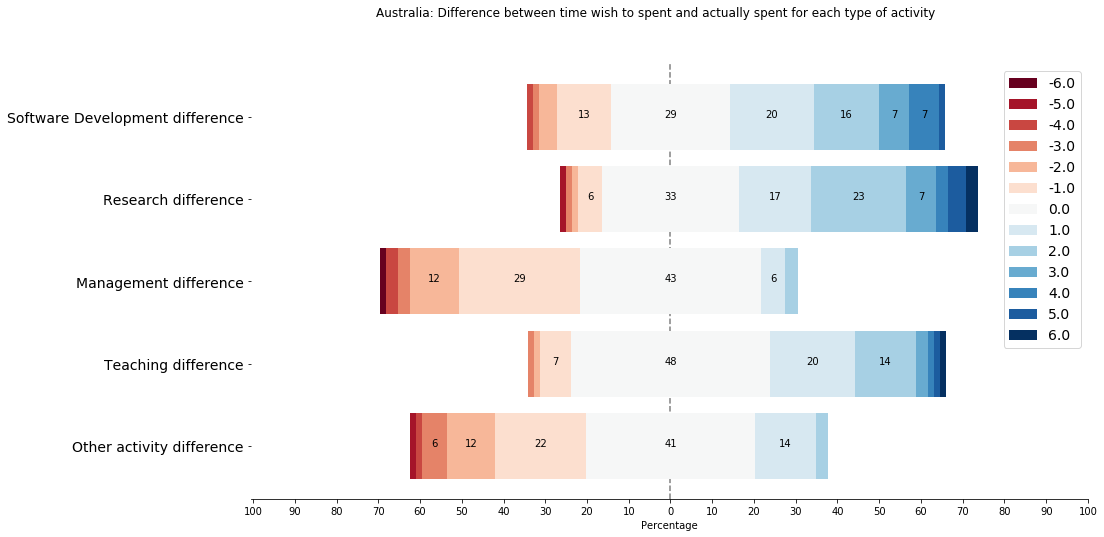

In [76]:
# Plotting the likert scale
country = 'Australia'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### Germany

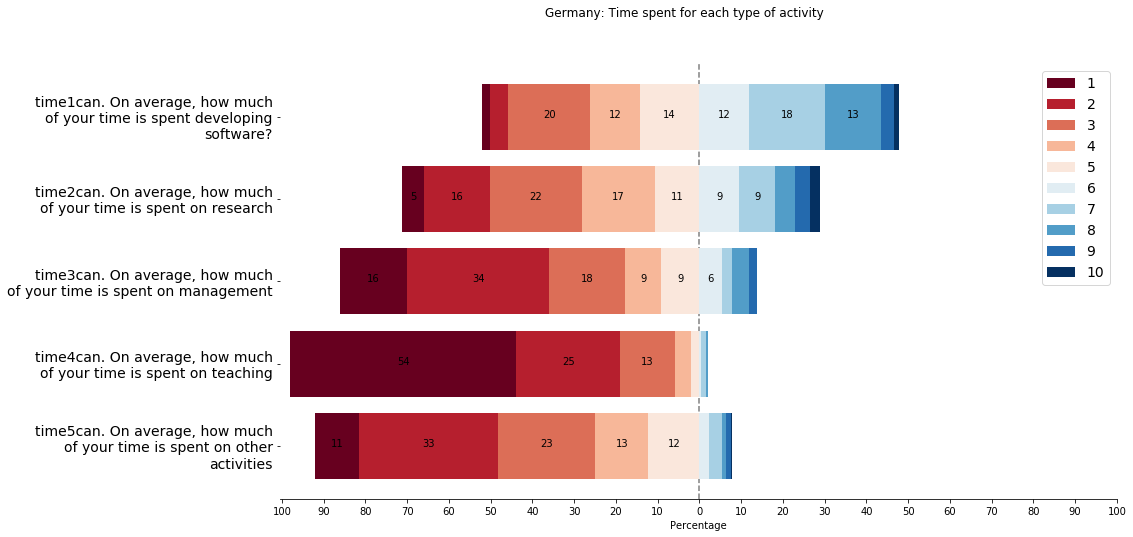

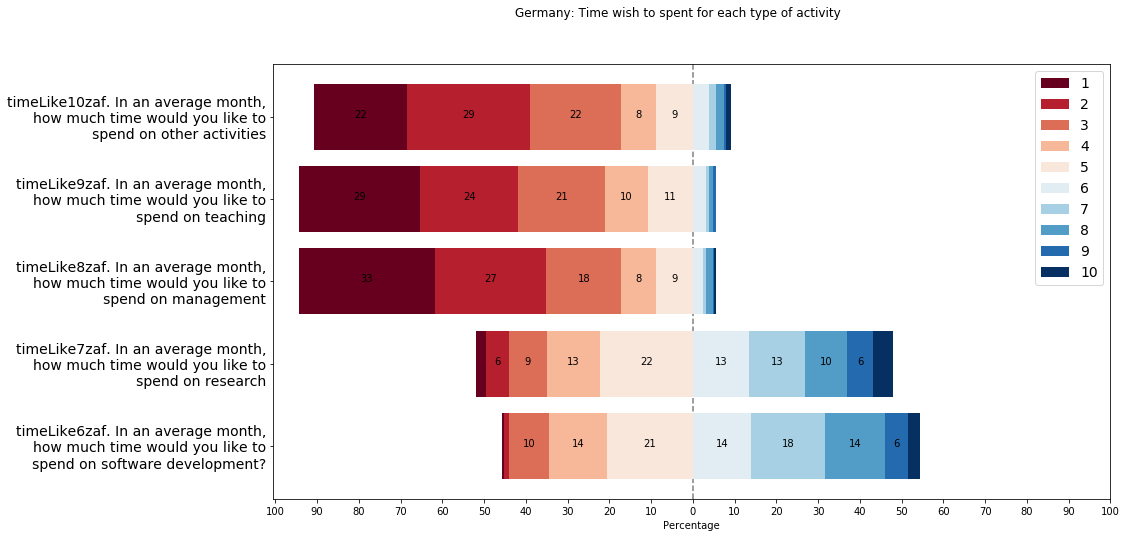

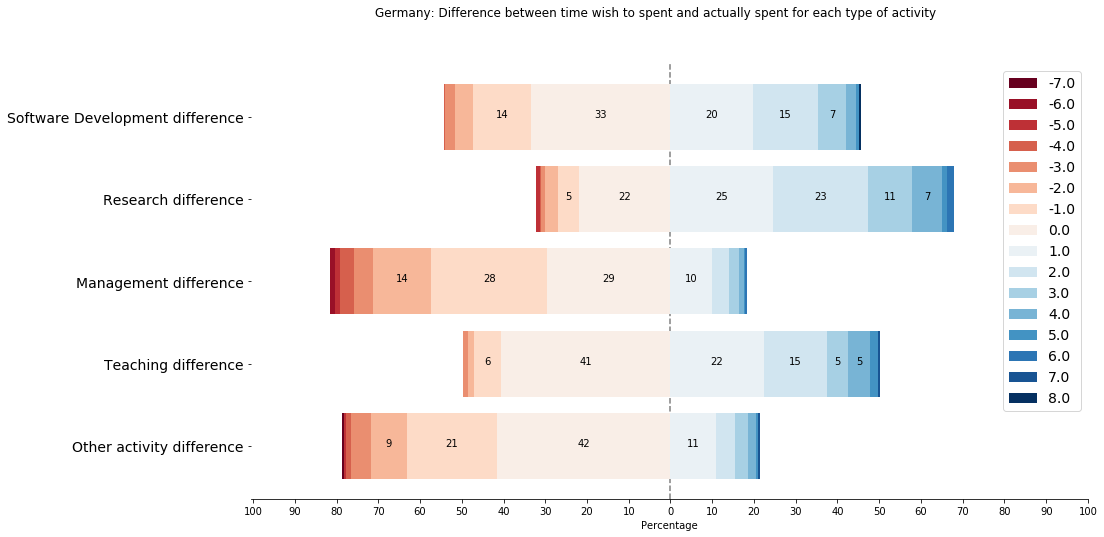

In [77]:
# Plotting the likert scale
country = 'Germany'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### Netherlands

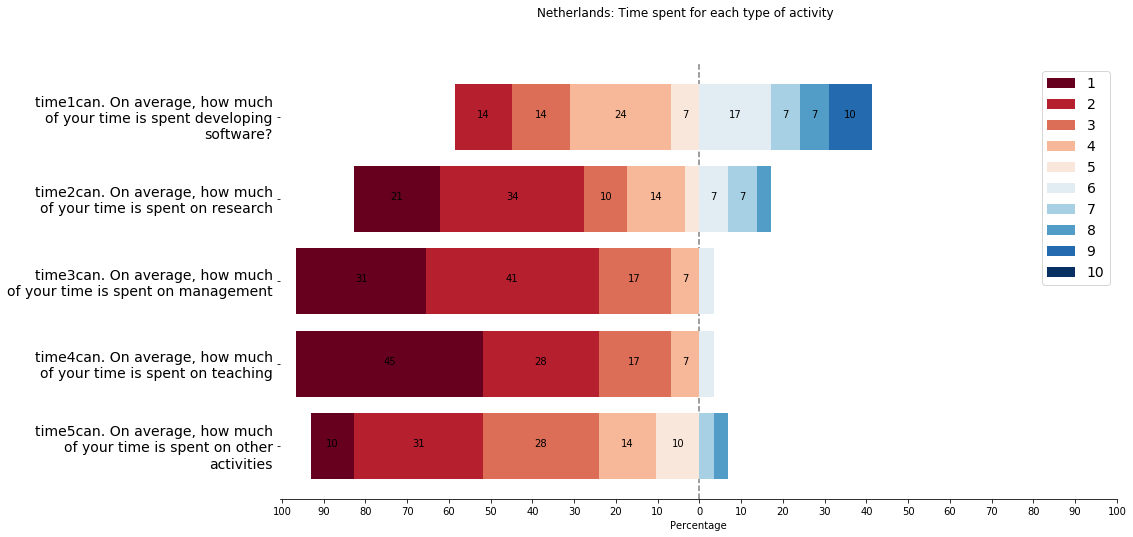

In [78]:
# Plotting the likert scale
country = 'Netherlands'
plotting_time_likert(country, df_time_spent)

### New Zealand

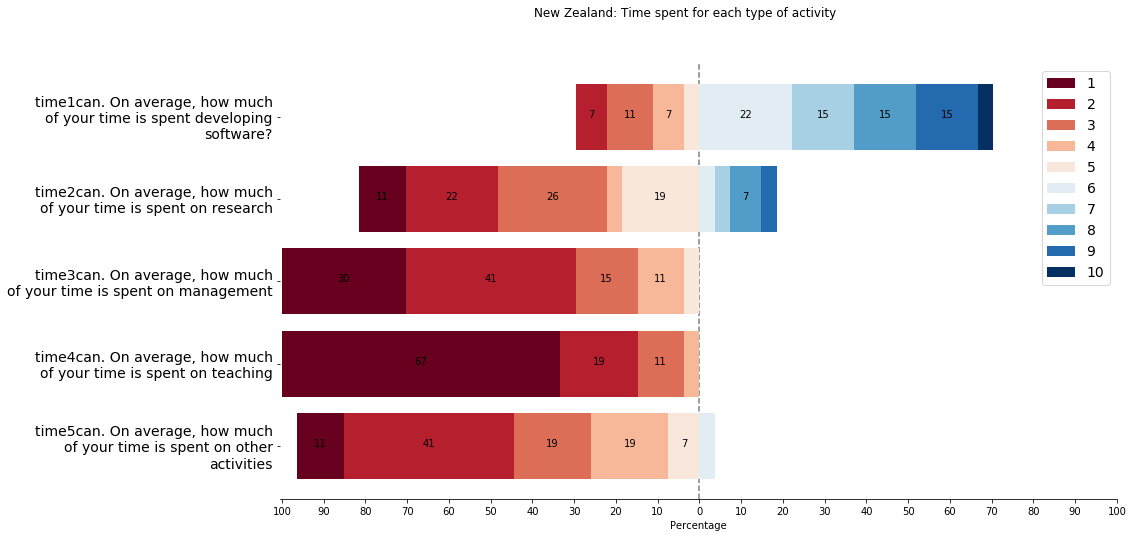

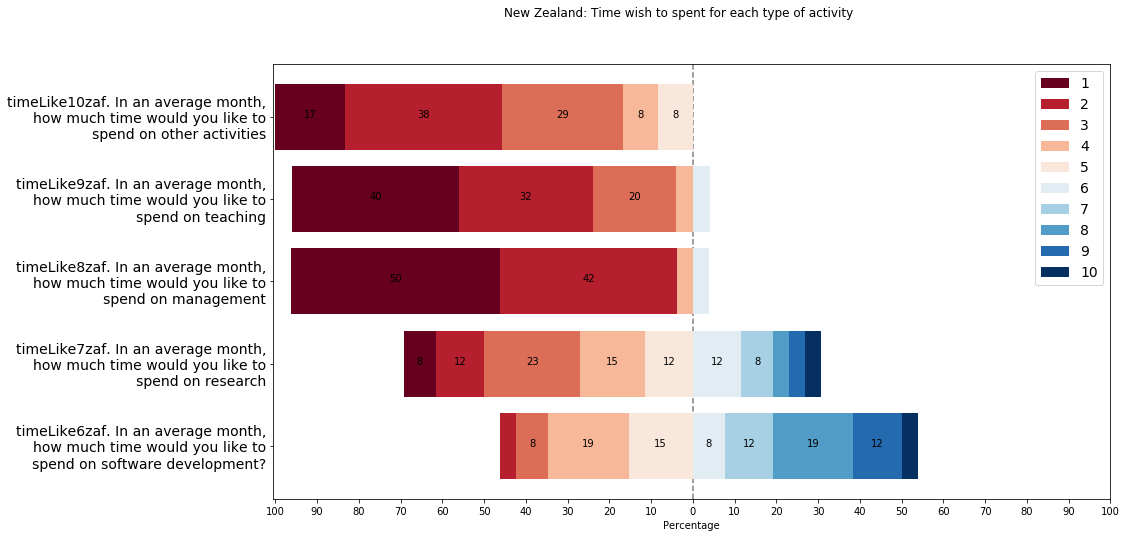

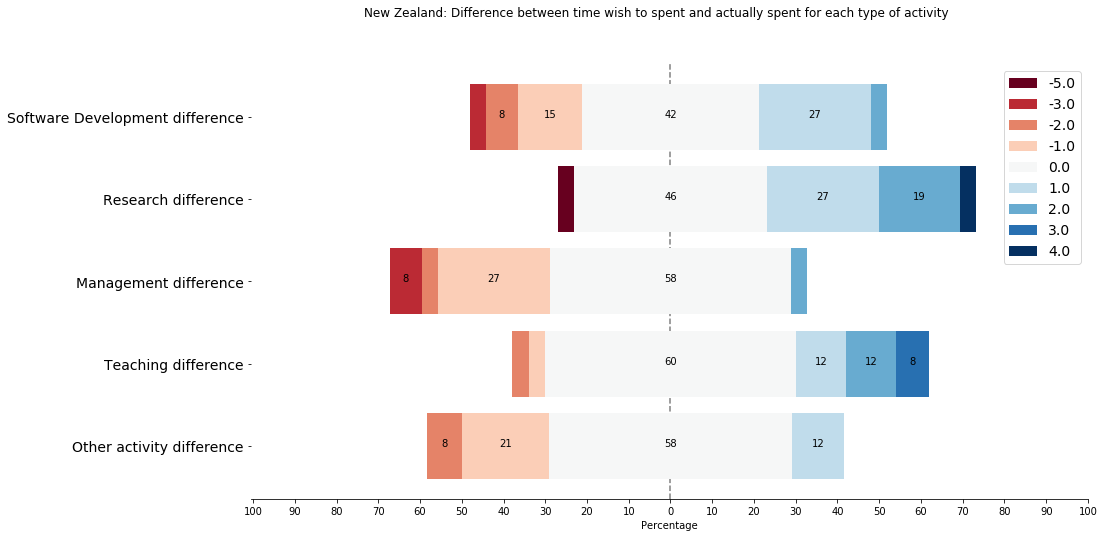

In [79]:
# Plotting the likert scale
country = 'New Zealand'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### South Africa

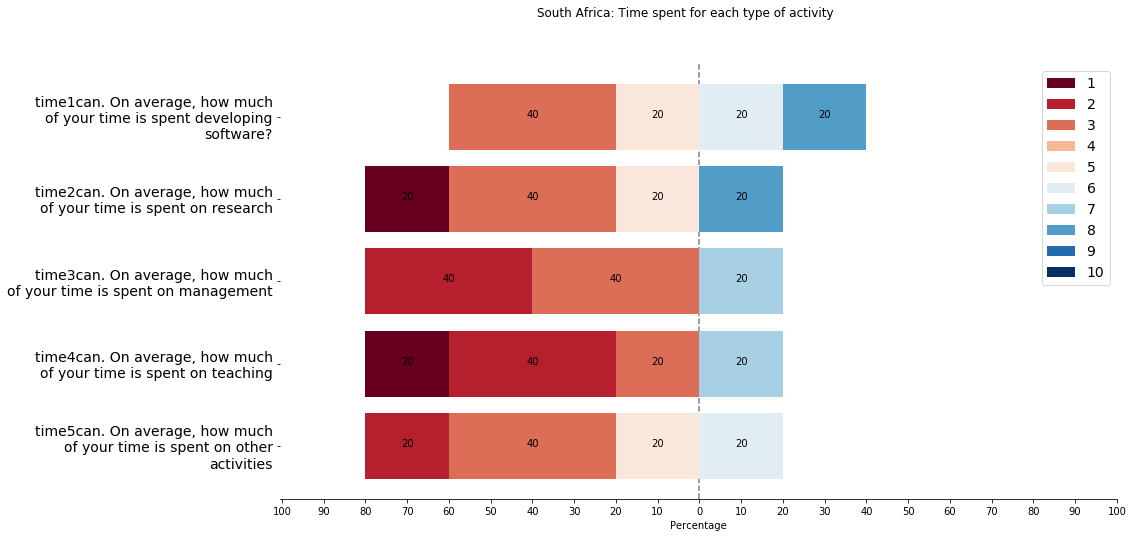

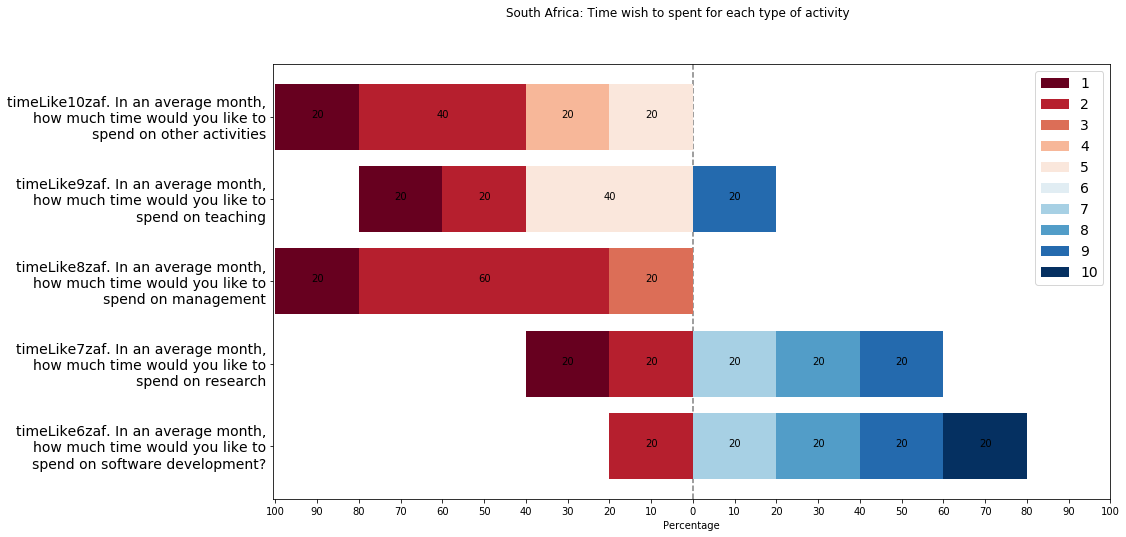

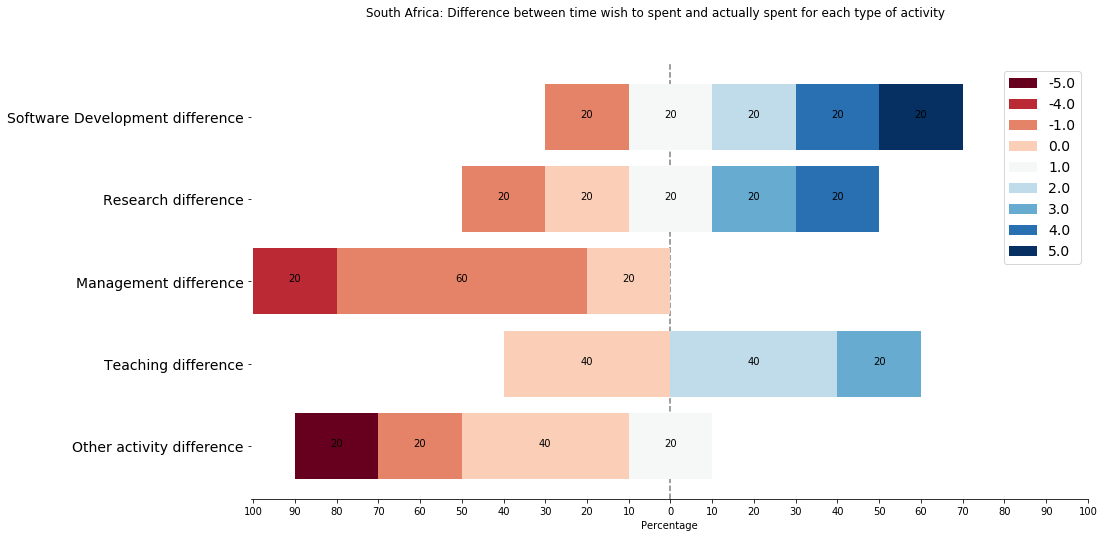

In [80]:
# Plotting the likert scale
country = 'South Africa'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### United Kingdom

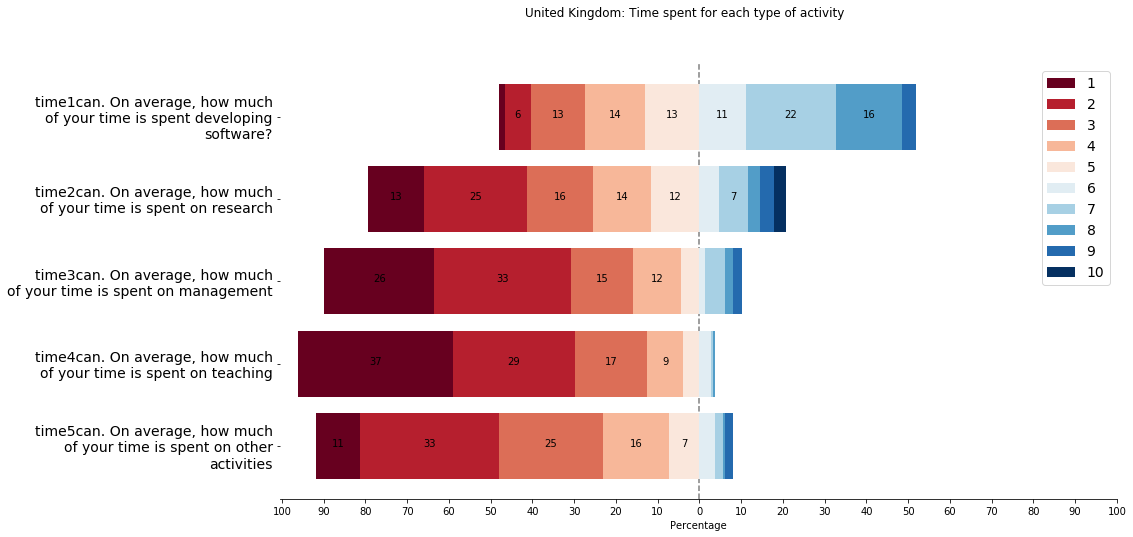

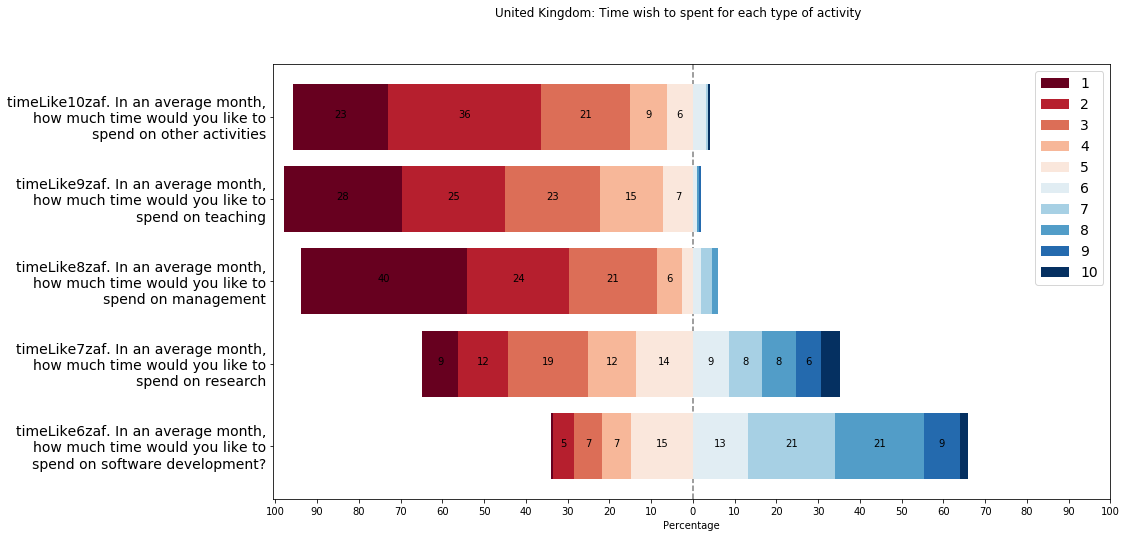

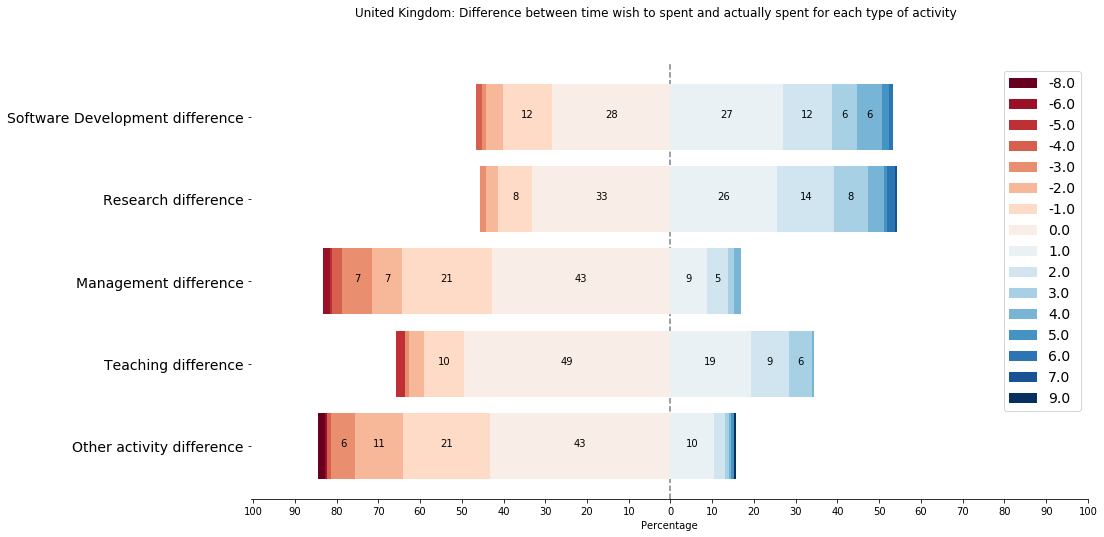

In [81]:
# Plotting the likert scale
country = 'United Kingdom'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### United States

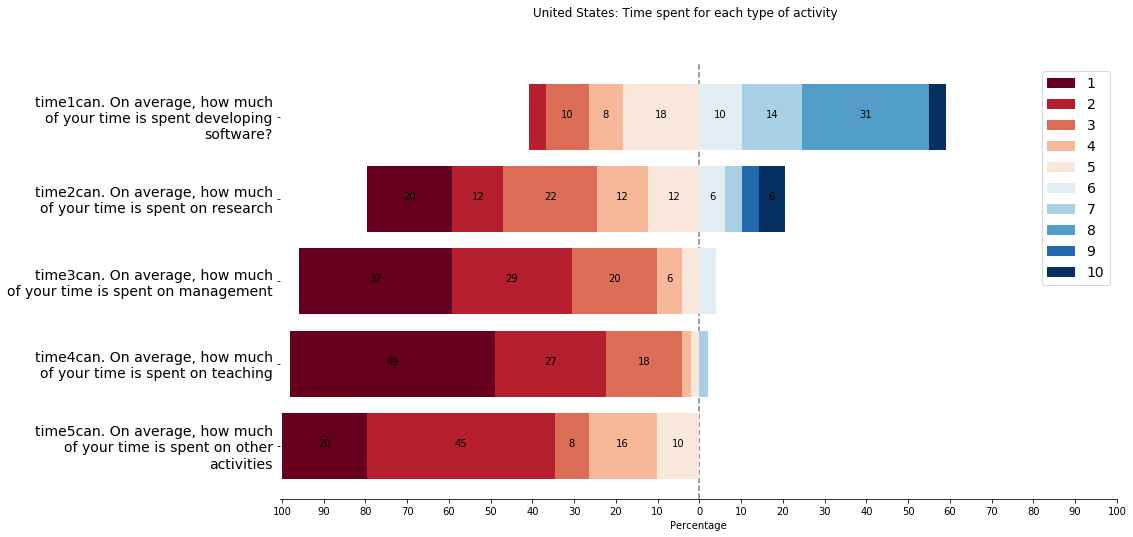

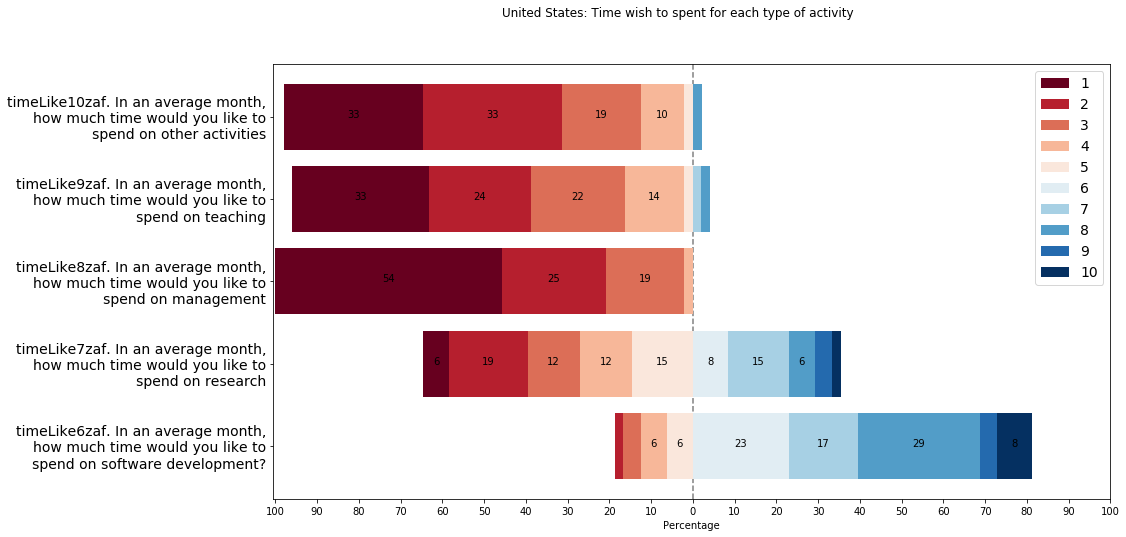

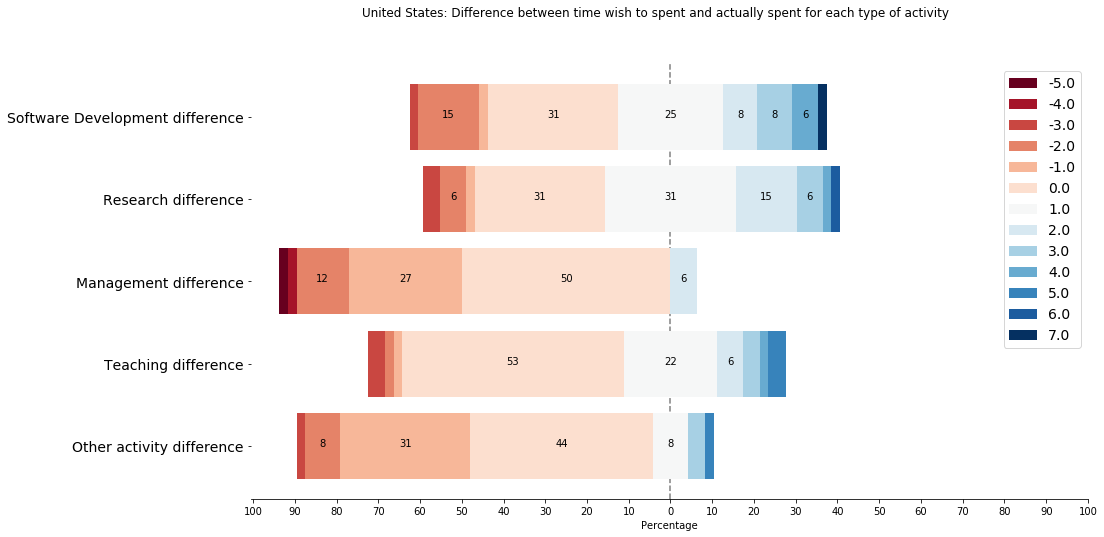

In [82]:
# Plotting the likert scale
country = 'United States'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)

### Rest of the World

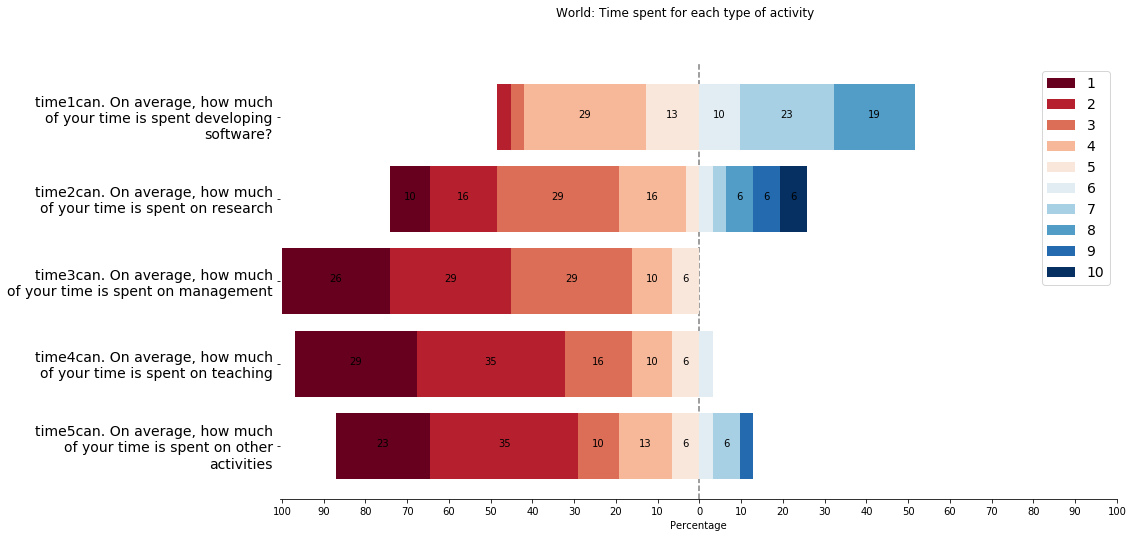

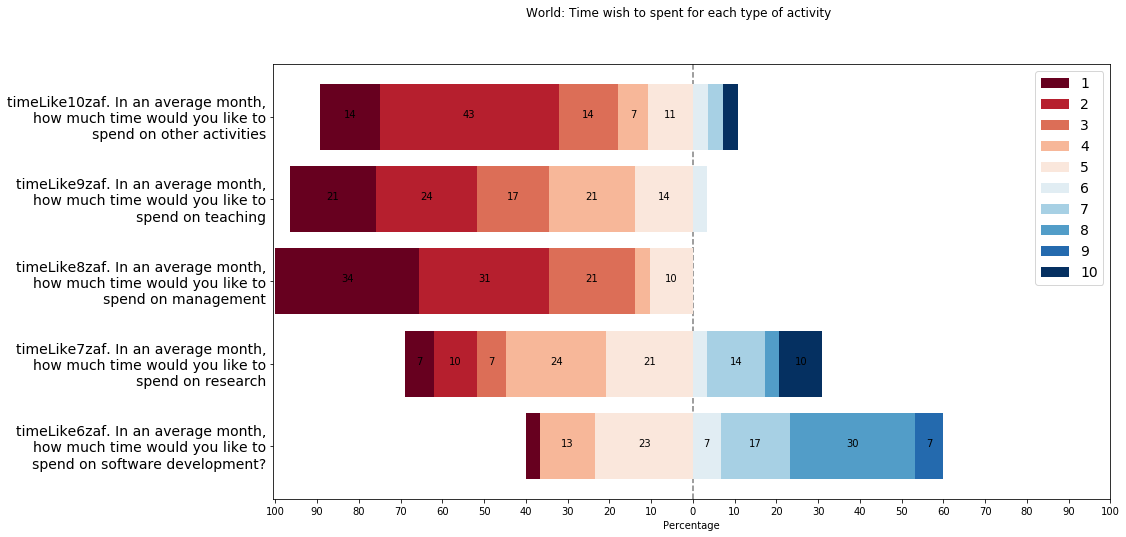

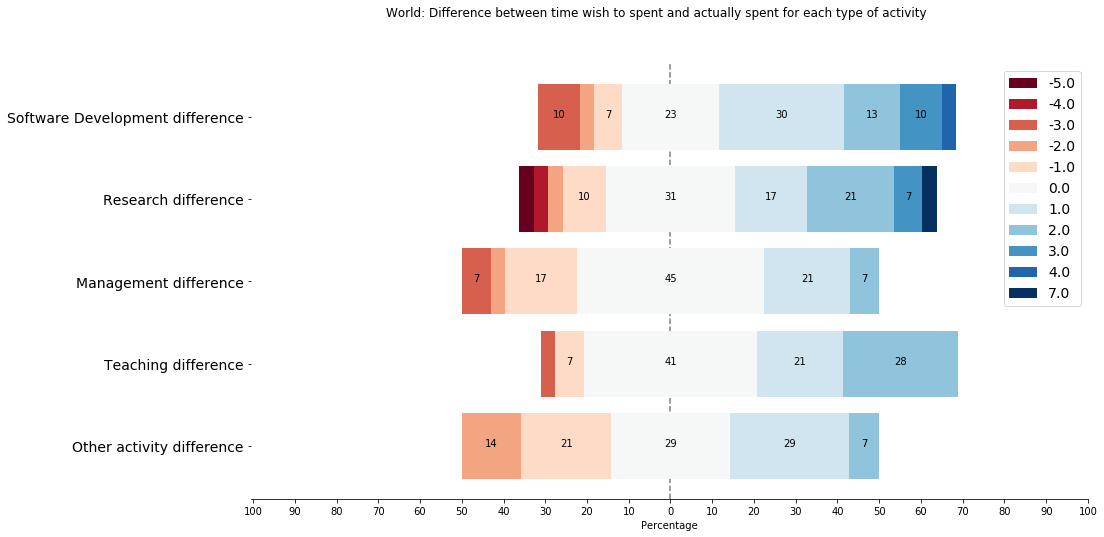

In [83]:
# Plotting the likert scale
country = 'World'
plotting_time_likert(country, df_time_spent, df_time_wish, df_time_diff)